In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import numpy as np
import re
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
%matplotlib inline

In [2]:

pd.options.display.max_columns = None

# DATA SOURCE


DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [December 3 2024] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

# Data Underdstanding

In [3]:
#Test Data
test_set_values_df = pd.read_csv("data/Test_set_values.csv")
test_set_values_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,Yombo,Pwani,6,1,Bagamoyo,Yombo,20,True,GeoData Consultants Ltd,VWC,Bagamoyo wate,True,1988,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,Mkondoa,Tanga,4,7,Kilindi,Mvungwe,2960,True,GeoData Consultants Ltd,VWC,NaN,False,1994,nira/tanira,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,Juhudi,Singida,13,2,Singida Rural,Ughandi,200,True,GeoData Consultants Ltd,VWC,NaN,NaN,2010,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,Namakinga B,Ruvuma,10,2,Songea Rural,Maposeni,150,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa maposeni,True,2009,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [4]:
# Data to be used
Training_set_values_df = pd.read_csv("data/Training_set_values.csv")
Training_set_values_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [5]:
# Predictor y label
Training_set_labels_df = pd.read_csv("data/Training_set_labels.csv")
Training_set_labels_df

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [6]:
# Merge Dataset
# Merging the train x data to its y predictor
df_merge = pd.merge(Training_set_labels_df,Training_set_values_df,how= "inner", on = "id")

In [7]:
df_merge.sample(20)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
42893,73630,functional needs repair,0.0,2011-03-28,Government Of Tanzania,0,Gover,36.407434,-6.967461,Zahanati,0,Rufiji,Massa,Dodoma,1,1,Mpwapwa,Massa,0,True,GeoData Consultants Ltd,VWC,Chog,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
2593,48222,functional,0.0,2013-03-15,Peter Tesha,1177,DWE,37.360406,-3.272725,Kireiyo,0,Pangani,Kireiyo,Kilimanjaro,3,4,Moshi Rural,Uru Shimbwe,50,True,GeoData Consultants Ltd,VWC,Uru shimbwe,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
57235,37202,functional,0.0,2011-02-27,Nethalan,341,DWE,37.532216,-6.264713,Kata,0,Wami / Ruvu,Ofisi Yakijiji,Morogoro,5,6,Mvomero,Hembeti,1,True,GeoData Consultants Ltd,VWC,Dimamba,True,1984,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
22505,35325,functional,0.0,2012-10-11,Rural Water Supply And Sanitat,0,DWE,32.072198,-3.471429,Mama Na Maji,0,Lake Tanganyika,Ituga Magharibi,Shinyanga,17,5,Bukombe,Bukombe,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
24769,2482,non functional,1000.0,2013-02-16,District Council,708,District Counci,37.675430,-3.515190,Kwa Eliwaza,0,Pangani,Kitogoto,Kilimanjaro,3,2,Mwanga,Jipe,60,True,GeoData Consultants Ltd,VWC,Kitogoto Water Supply,True,2008,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,other,other
23080,73672,non functional,0.0,2013-02-05,Fw,114,FW,39.050569,-11.114086,Darajani,0,Ruvuma / Southern Coast,Mkapita,Mtwara,90,33,Masasi,Sindano,1,True,GeoData Consultants Ltd,VWC,NaN,True,1978,other,other,other,vwc,user-group,unknown,unknown,salty,salty,dry,dry,shallow well,shallow well,groundwater,other,other
39683,33199,functional needs repair,600.0,2013-01-28,Isf,792,DWE,29.736374,-4.902588,Kwa Ali Kinaga,0,Lake Tanganyika,Bondo,Kigoma,16,3,Kigoma Rural,Simbo,155,True,GeoData Consultants Ltd,WUG,Mkongoro Two,True,2009,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe
9631,20190,functional,0.0,2012-10-22,Dwsp,0,DWSP,33.371401,-3.791166,Samuye Shuleni,0,Internal,Mwalula,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,Parastatal,NaN,True,0,nira/tanira,nira/tanira,handpump,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
54395,66605,functional,0.0,2012-10-09,Dwsp,0,DWE,33.476441,-3.631108,Kwa Mzee Nyesha,0,Internal,Mpera C,Shinyanga,17,7,Shinyanga Urban,Ibadakuli,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,0,afridev,afridev,handpump,wug,user-group,unknown,unknown,salty,salty,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump
49339,71942,functional,250.0,2013-01-18,Dwe,1270,DWE,30.381895,-4.369798,Kwa Andrea,0,Lake Tanganyika,Kasasa,Kigoma,16,2,Kasulu,Kitagata,350,True,GeoData Consultants Ltd,Water authority,Nyachenda,True,2009,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


In [8]:
# Getting basic information on the merged dataset
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [9]:
# Checking the columns available in our dataset
df_merge.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [10]:
# finding the shape of our dataset
df_merge.shape

(59400, 41)

In [11]:
# finding unique values in each column

object_columns = df_merge.select_dtypes(include=['object','int64','float64']).columns

object_column_unique = {col : df_merge[col].nunique() for col in object_columns}

columns_unique_df =pd.DataFrame(list(object_column_unique.items()), columns= ['column_name', 'number_of_unique_values'])
columns_unique_df


,column_name,number_of_unique_values
0,id,59400
1,status_group,3
2,amount_tsh,98
3,date_recorded,356
4,funder,1897
5,gps_height,2428
6,installer,2145
7,longitude,57516
8,latitude,57517
9,wpt_name,37400


## Basic understanding of each of the columns based on their cardinality

**High Cardinality columns**
- id (59400) = Unique values are equal to the total number of rows of dataframe indicating its the unique identifier of the dataset
- longitude and latitude = indicates that the wells are spread on a huge geographical region
- wpt_name = indicates a large variety on water point names
- sub_villages = indicates wells are located on a high number of unique sub-villages

**Medium Cardinality columns**

- funder = indicates a huge number of funders i.e people who funded the project
- gps_height = indicates a large number of wells were built along multiple altitude heights
- ward -Indicates wells are found in multiple different wards
- installer - indicates that there are multiple organizations that have constructed wells in Tanzania
- scheme_name - Indicates there are a lot of different water schemes in the area
- amount_tsh (98)-  this represents the total static head this means the elevation between the free level of water till the discharge point of the pump

**Low Cardinality Columns**
- status group = indicates the three types of status a well might be i.e functional, non-functional, functional but in need of repair
- public meeting (2) = Indicates a boolean value where its either a yes or no
- management_group (5) = Indicates there are 5 unique ways a well may be managed
- permit (2) = shows a well can be built having a permit or no permit
- source_class = shows the classification of the source of the water



## numerical columns that are distinct
- id
- longitude and latitude
- region code 
- district code
- construction year


In [12]:
df_merge.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


- amount_total_static_head = the min amount is 0, the mean value is 317.65. There is also an indication that majority of the values are 0 because the 1st quartile and the median being 0
- gps_height = min value is -90 might indicate the wells are located below sea level
- population = min amount is 0. This might be an error or indicates that the area where the wells are have no poulation while the maximum is 30500

# Data Cleaning


In [13]:
# checking the number of null values in my dataset

df_merge.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

There are missing value in the following columns
- funder 
- installer 
- sub_village
- public_meeting
- scheme_management
- scheme_name
- permit

All this are categorical columns and missing values might be caused by missed information in the data collection process


In [14]:
# checking the information contained on the columns with the missing values

missing_cols = df_merge.columns[df_merge.isnull().any()]

df_merge.loc[: ,missing_cols].sample(20)

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
11751,Dwsp,DWE,Zizimi,NaN,WUG,NaN,False
45088,Peters,DWE,Nyamilima,True,VWC,NaN,True
9189,Germany Republi,CES,Matowo,True,Water Board,Uroki-Bomang'ombe water sup,True
41653,NaN,NaN,Mungaa,True,VWC,M,NaN
26119,World Vision,World Vision,Shalenhwa,False,VWC,NaN,False
23198,Danida,DWE,M,True,VWC,NaN,True
2610,World Bank,DWE,Urumia,True,VWC,Ilas,False
5470,Rc Church,RC CHURCH,Ilandachi,True,VWC,MAKOGA WATER SUPPLY,False
49,District Council,DWE,Ikanga,True,VWC,wangama water supply scheme,True
50817,Go,Go,Chakwale Mjini,True,VWC,Ga,True


In [15]:
# for categorical columns that explain extra information on the well we can fill null values by the word unknown i.e funder, installer , subvillage, scheme_management, scheme_name

df_merge[['funder', 'installer', 'subvillage','scheme_management','scheme_name']] = df_merge[['funder', 'installer', 'subvillage','scheme_management','scheme_name']].fillna("unknown")


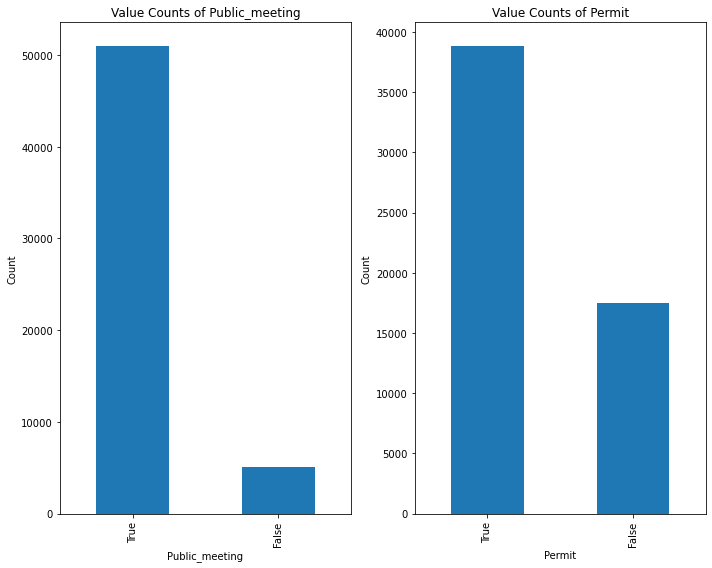

In [16]:
# for the remaining lets check the value counts as they are boolean values i.e between two choices

object_columns = df_merge.columns[df_merge.isna().any()]

fig,ax= plt.subplots(nrows= 1, ncols = 2 ,figsize=(10,8))

for i,col in enumerate(object_columns) :
    df_merge[col].value_counts().plot(kind= 'bar', ax= ax[i])
    ax[i].set_title(f'Value Counts of {col.capitalize()}') 
    ax[i].set_xlabel(col.capitalize()) 
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()



- We can see that most wells go through a public meeting before being built
- Most wells have permits before being built 

In [17]:
# filling missing values in both this fields by the modes of their columns

df_merge = df_merge.apply(lambda x: x.fillna(x.value_counts().index[0]))



In [18]:
df_merge.isna().sum()

id                       0
status_group             0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
s

In [19]:
# lets check for instances of duplication
# will check for duplicates in all columns except the first column i.e the primary key of this dataset

df_duplicated =df_merge[df_merge.iloc[:, 1:].duplicated(keep= False)]

In [20]:
sorted_duplicates = df_duplicated.sort_values(by=df_merge.columns[1:].tolist())
sorted_duplicates.head(20)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
17451,29553,functional,0.0,2011-07-13,He,0,HE,31.61953,-1.793342e+00,Kahindu,0,Lake Victoria,Ikondoa,Kagera,18,3,Muleba,Ikondo,0,True,GeoData Consultants Ltd,VWC,unknown,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
39187,18713,functional,0.0,2011-07-13,He,0,HE,31.61953,-1.793342e+00,Kahindu,0,Lake Victoria,Ikondoa,Kagera,18,3,Muleba,Ikondo,0,True,GeoData Consultants Ltd,VWC,unknown,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
326,7900,functional,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Hospital,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
28518,68204,functional,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Hospital,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
40696,28134,functional,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Hospital,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
301,70379,functional,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Nersing College,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,0,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
56268,70312,functional,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Nersing College,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,0,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
15097,64405,functional,0.0,2011-07-19,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,K/Secondary,0,Lake Victoria,Kisese,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,14 Kambarage,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
37439,56859,functional,0.0,2011-07-19,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,K/Secondary,0,Lake Victoria,Kisese,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,14 Kambarage,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
19733,32781,functional,0.0,2011-07-19,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Mulangila,0,Lake Victoria,14Kambalage,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultan

In [21]:
# Dropping duplicated data

df_merge = df_merge.drop_duplicates(subset = df_merge.columns[1:], keep= 'first')

In [22]:
df_merge.shape

(59364, 41)

In [23]:
df_cleaned = df_merge.copy()

# Univariate analysis

## Categorical columns

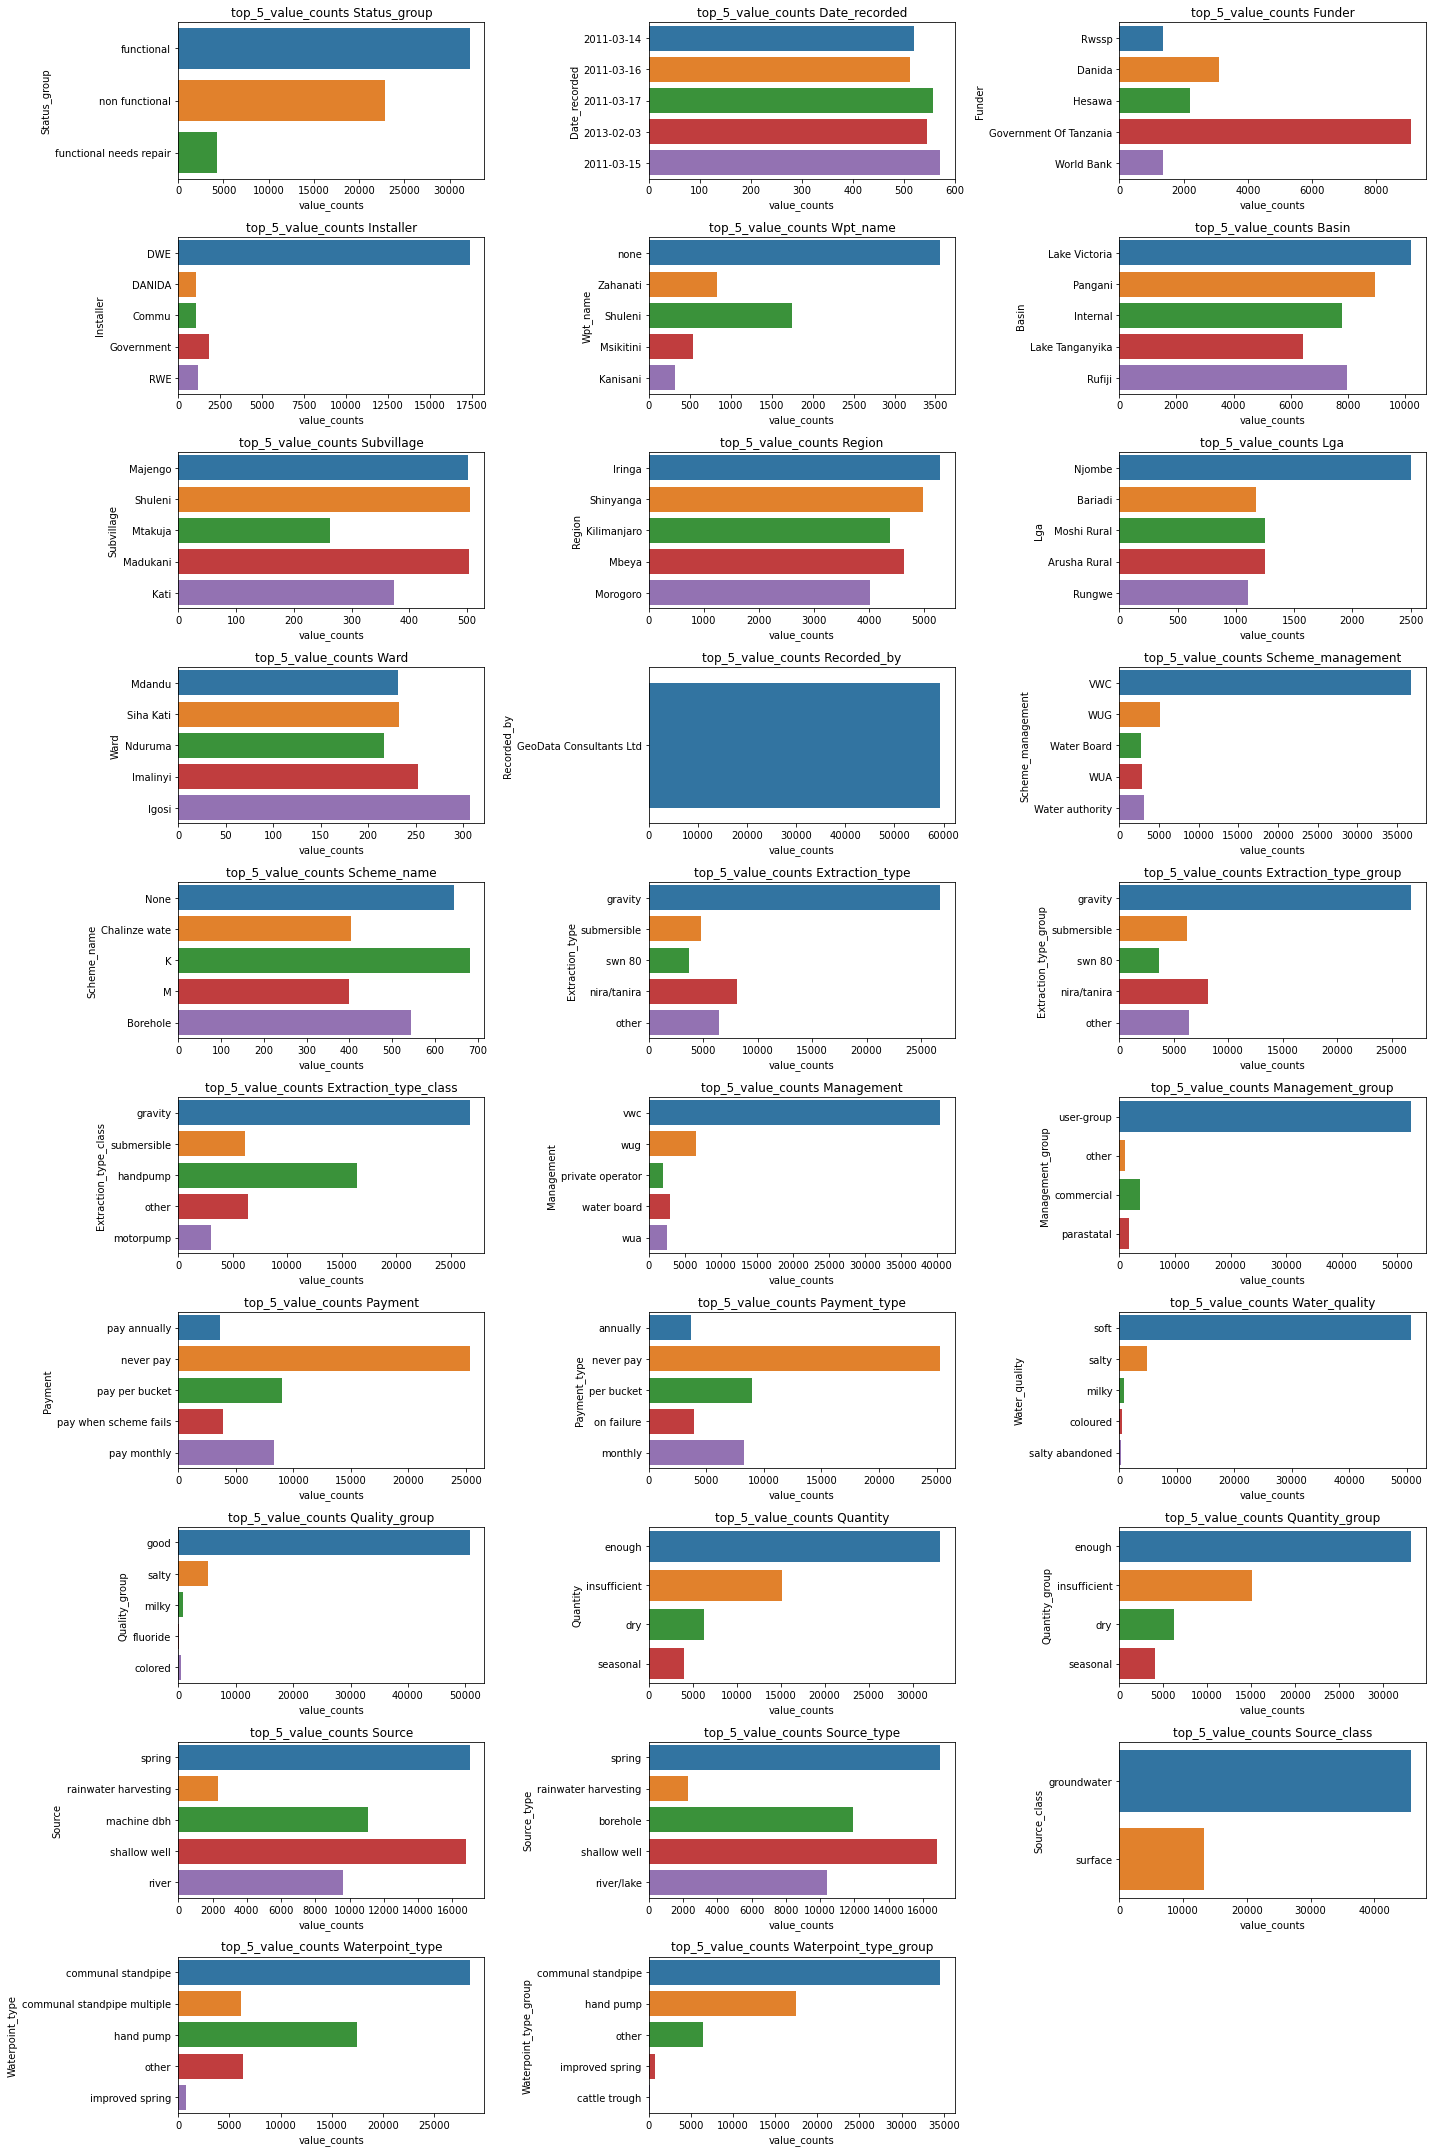

In [24]:
# lets create visualisations to look at value counts of all data types that are object

object_columns = df_cleaned.select_dtypes(include = "object").columns

# initializing the columns to be on the figure
number_of_cols = 3
fig, axes = plt.subplots(nrows= math.ceil(len(object_columns)/ number_of_cols),ncols= number_of_cols, figsize=(20,30))
# Flatten the axes for easier iteration
axes = axes.flatten()
for i, col in enumerate(object_columns):
    # Filter out 'unknown' values 
    filtered_data = df_cleaned[df_cleaned[col] != 'unknown']
    top_values= filtered_data[col].value_counts().nlargest(5).index
    sns.countplot(y = col, data = filtered_data[filtered_data[col].isin(top_values)],ax= axes[i])
    axes[i].set_title(f'top_5_value_counts {col.capitalize()}')
    axes[i].set_ylabel(col.capitalize())
    axes[i].set_xlabel("value_counts")

#removing any extra subplots that may form
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




### Insights
- **Status group** : most water points are considered to be functional, followed by non_functional and lastly functional but in need of repair
- **Recorded_by** :all records were recorded by the same company. These column can be removed as it wont provide any information for our model
- **funder** :govt of Tanzania has funded majority of the projects, followed by "Danida","Hesawa","Rwsp","World bank"
- **installer** : The leading installer is DWE(District Water Engineer). This indicates districts have hired water engineers to install the pumps followed by"Danida", "Commu","Government","RWE(Region Water Engineer)"
- **Source_class**:Majority of water is obtained from groundwater the rest is surface water
- **Basin** :majority of the walls points source their water from Lake Victoria, followed by lake Tanganyika,Lake Pangani and Lake Rufiji
- **Payment** : majority of the water points the population do not pay to access the water
- **Waterpoint type**In majority of the water points there is a communal standpipe
- **Water Quantity** :majority of the water points have water that is regarded enough by the residents in the area
- **Extraction type** :majority of the water points use gravity to extract water from its source
- **Extraction type class** : majority of the pumps are considered to be in the class of gravity
- **scheme_management** :majority of the water points are managed through vwc (Village Water Committee) followed by WUG (Water User Group), WUA (Water User Association), Water Board, Water Authority


Further Investigation

From the visualisions we discover that some columns contain similar information found in other columns example
- quantity and quantity_group
- extraction_type and extraction_type_class
- source and source_type
- payment and payment_type
- waterpoint_type and waterpoint_type_group
- management and management_group






### Removing duplicated columns

In [25]:
def get_value_counts(df, col):
    return df[col].value_counts()

In [26]:
quantity= get_value_counts(df= df_cleaned,col ='quantity')
quantity_group = get_value_counts(df= df_cleaned,col= 'quantity_group')

quantity,quantity_group

(enough          33165
 insufficient    15119
 dry              6243
 seasonal         4048
 unknown           789
 Name: quantity, dtype: int64,
 enough          33165
 insufficient    15119
 dry              6243
 seasonal         4048
 unknown           789
 Name: quantity_group, dtype: int64)

In [27]:
# we can remove one of these columns as they are duplicate of each other and also recorded by

df_cleaned.drop(columns=["quantity_group",'recorded_by'], inplace = True)

In [28]:
extraction_type = get_value_counts(df_cleaned,'extraction_type')
extraction_group = get_value_counts(df_cleaned,'extraction_type_group')
extraction_class = get_value_counts(df_cleaned,'extraction_type_class')

extraction_type,extraction_group,extraction_class

(gravity                      26776
 nira/tanira                   8143
 other                         6427
 submersible                   4759
 swn 80                        3663
 mono                          2865
 india mark ii                 2398
 afridev                       1769
 ksb                           1413
 other - rope pump              451
 other - swn 81                 229
 windmill                       117
 india mark iii                  97
 cemo                            90
 other - play pump               85
 walimi                          48
 climax                          32
 other - mkulima/shinyanga        2
 Name: extraction_type, dtype: int64,
 gravity            26776
 nira/tanira         8143
 other               6427
 submersible         6172
 swn 80              3663
 mono                2865
 india mark ii       2398
 afridev             1769
 rope pump            451
 other handpump       364
 other motorpump      122
 wind-powered         117
 i

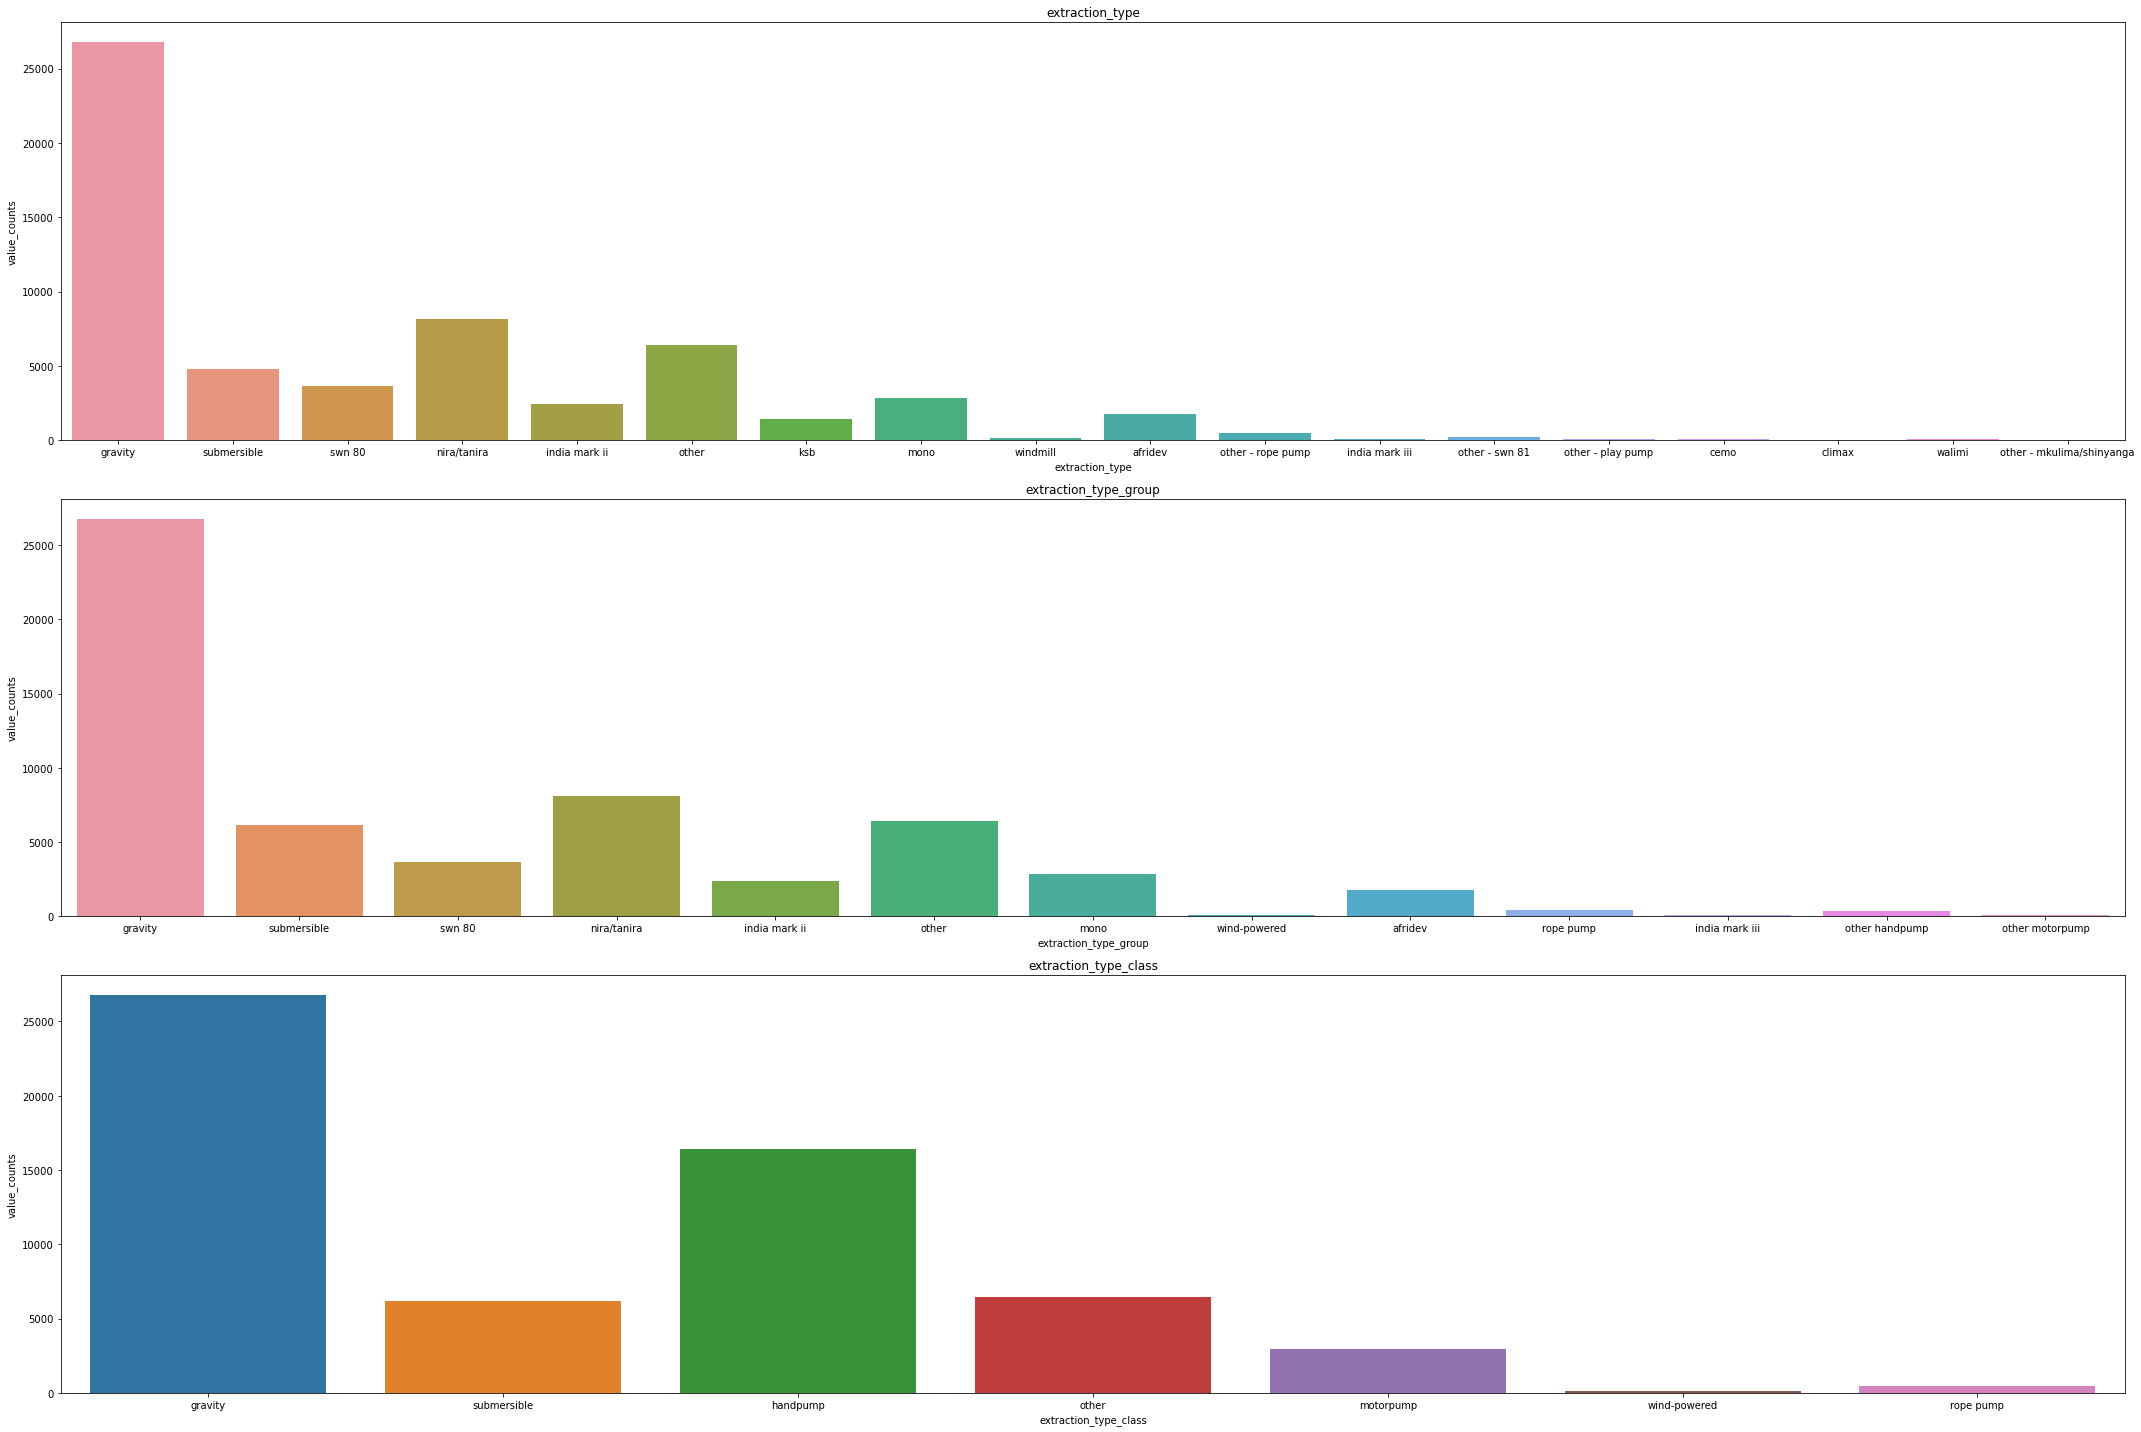

In [29]:
# checking extraction group value counts
extraction_columns= ['extraction_type','extraction_type_group','extraction_type_class']

fig,axes = plt.subplots( nrows= 3, ncols= 1, figsize = (30,20))

axes= axes.flatten()
for i,col in enumerate(extraction_columns):
    sns.countplot(x= col, data = df_cleaned, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('value_counts')

plt.tight_layout()
plt.show()


Extraction type class seems to group the type group data well so we are going to drop extraction_type_group and extraction_type

In [30]:
df_cleaned.drop(columns=['extraction_type_group','extraction_type'], inplace = True)

In [31]:
source= get_value_counts(df_cleaned,'source')
source_type= get_value_counts(df_cleaned,'source_type')

source,source_type


(spring                  17020
 shallow well            16801
 machine dbh             11069
 river                    9612
 rainwater harvesting     2293
 hand dtw                  874
 lake                      763
 dam                       655
 other                     211
 unknown                    66
 Name: source, dtype: int64,
 spring                  17020
 shallow well            16801
 borehole                11943
 river/lake              10375
 rainwater harvesting     2293
 dam                       655
 other                     277
 Name: source_type, dtype: int64)

In [32]:
# the columns again seem to hold similar information therefore we are going to drop source and remain with source type

df_cleaned.drop(columns="source", inplace = True)

In [33]:
waterpoint=get_value_counts(df_cleaned,'waterpoint_type')
waterpoint_group = get_value_counts(df_cleaned,'waterpoint_type_group')

waterpoint,waterpoint_group

(communal standpipe             28516
 hand pump                      17466
 other                           6377
 communal standpipe multiple     6099
 improved spring                  783
 cattle trough                    116
 dam                                7
 Name: waterpoint_type, dtype: int64,
 communal standpipe    34615
 hand pump             17466
 other                  6377
 improved spring         783
 cattle trough           116
 dam                       7
 Name: waterpoint_type_group, dtype: int64)

In [34]:
# The columns have similar information we will again use the group option

df_cleaned.drop(columns="waterpoint_type", inplace = True)


In [35]:
payment= get_value_counts(df_cleaned,"payment")
payment_group = get_value_counts(df_cleaned,"payment_type")

payment,payment_group

(never pay                25337
 pay per bucket            8984
 pay monthly               8300
 unknown                   8134
 pay when scheme fails     3914
 pay annually              3642
 other                     1053
 Name: payment, dtype: int64,
 never pay     25337
 per bucket     8984
 monthly        8300
 unknown        8134
 on failure     3914
 annually       3642
 other          1053
 Name: payment_type, dtype: int64)

In [36]:
# The two columns are duplicate of each other

df_cleaned.drop(columns= "payment", inplace = True)

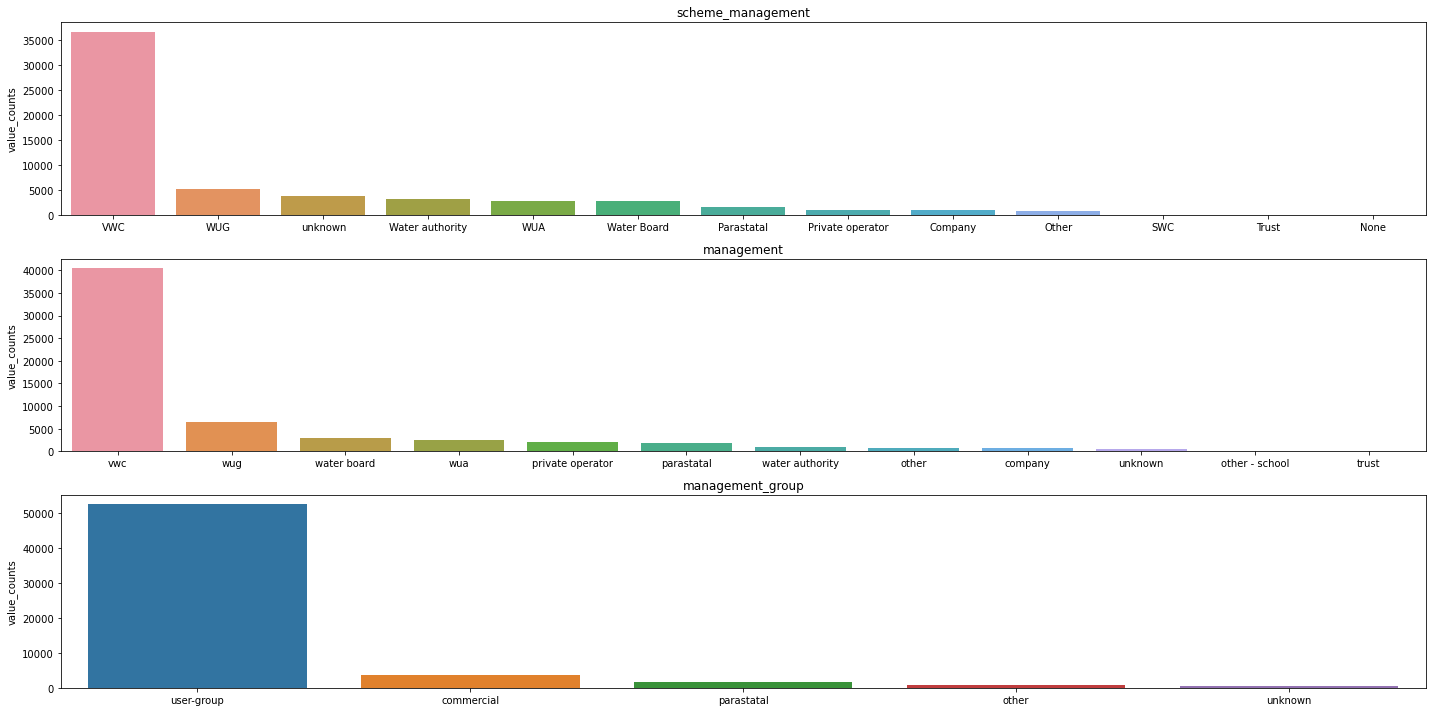

In [37]:
# plotting the three columns to get a better understanding on their contents
columns = ['scheme_management', 'management', 'management_group']
fig,axes = plt.subplots(nrows = 3, ncols= 1 , figsize = (20,10))

for i,col in enumerate(columns):
    sns.barplot(x= get_value_counts(df_cleaned,col).index, y=get_value_counts(df_cleaned,col).values, ax= axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("value_counts")
    
plt.tight_layout()
plt.show()

In [38]:

scheme_management= get_value_counts(df_cleaned,'scheme_management')
management= get_value_counts(df_cleaned,"management")
management_group = get_value_counts(df_cleaned,"management_group")

scheme_management,management,management_group

(VWC                 36779
 WUG                  5186
 unknown              3877
 Water authority      3153
 WUA                  2883
 Water Board          2748
 Parastatal           1678
 Private operator     1063
 Company              1061
 Other                 766
 SWC                    97
 Trust                  72
 None                    1
 Name: scheme_management, dtype: int64,
 vwc                 40493
 wug                  6495
 water board          2933
 wua                  2535
 private operator     1971
 parastatal           1766
 water authority       904
 other                 844
 company               685
 unknown               561
 other - school         99
 trust                  78
 Name: management, dtype: int64,
 user-group    52456
 commercial     3638
 parastatal     1766
 other           943
 unknown         561
 Name: management_group, dtype: int64)

It seems scheme managemnt is not similar to the management and management group

managemnt group is grouped in the following ways
- user-group = vwc + wug+ water board + wua
- commercial = private operator + water authority + company + trust
- parastatal = parastatal
- other = other + other - school
- unknown = unknown

with this understanding will take the management group column

In [39]:
df_cleaned.drop(columns= "management", inplace = True)

In [40]:
water_quality = get_value_counts(df_cleaned,'water_quality')
quality_group = get_value_counts(df_cleaned,'quality_group')

water_quality,quality_group
# the columns have similar information and we will use the group option

(soft                  50785
 salty                  4856
 unknown                1873
 milky                   804
 coloured                490
 salty abandoned         339
 fluoride                200
 fluoride abandoned       17
 Name: water_quality, dtype: int64,
 good        50785
 salty        5195
 unknown      1873
 milky         804
 colored       490
 fluoride      217
 Name: quality_group, dtype: int64)

In [41]:
df_cleaned.drop(columns= "water_quality", inplace = True)

In [42]:
df_cleaned.shape

(59364, 32)

## Numerical columns

In [43]:
df_cleaned.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,37117.957988,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,21451.843216,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18527.250000,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37063.500000,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


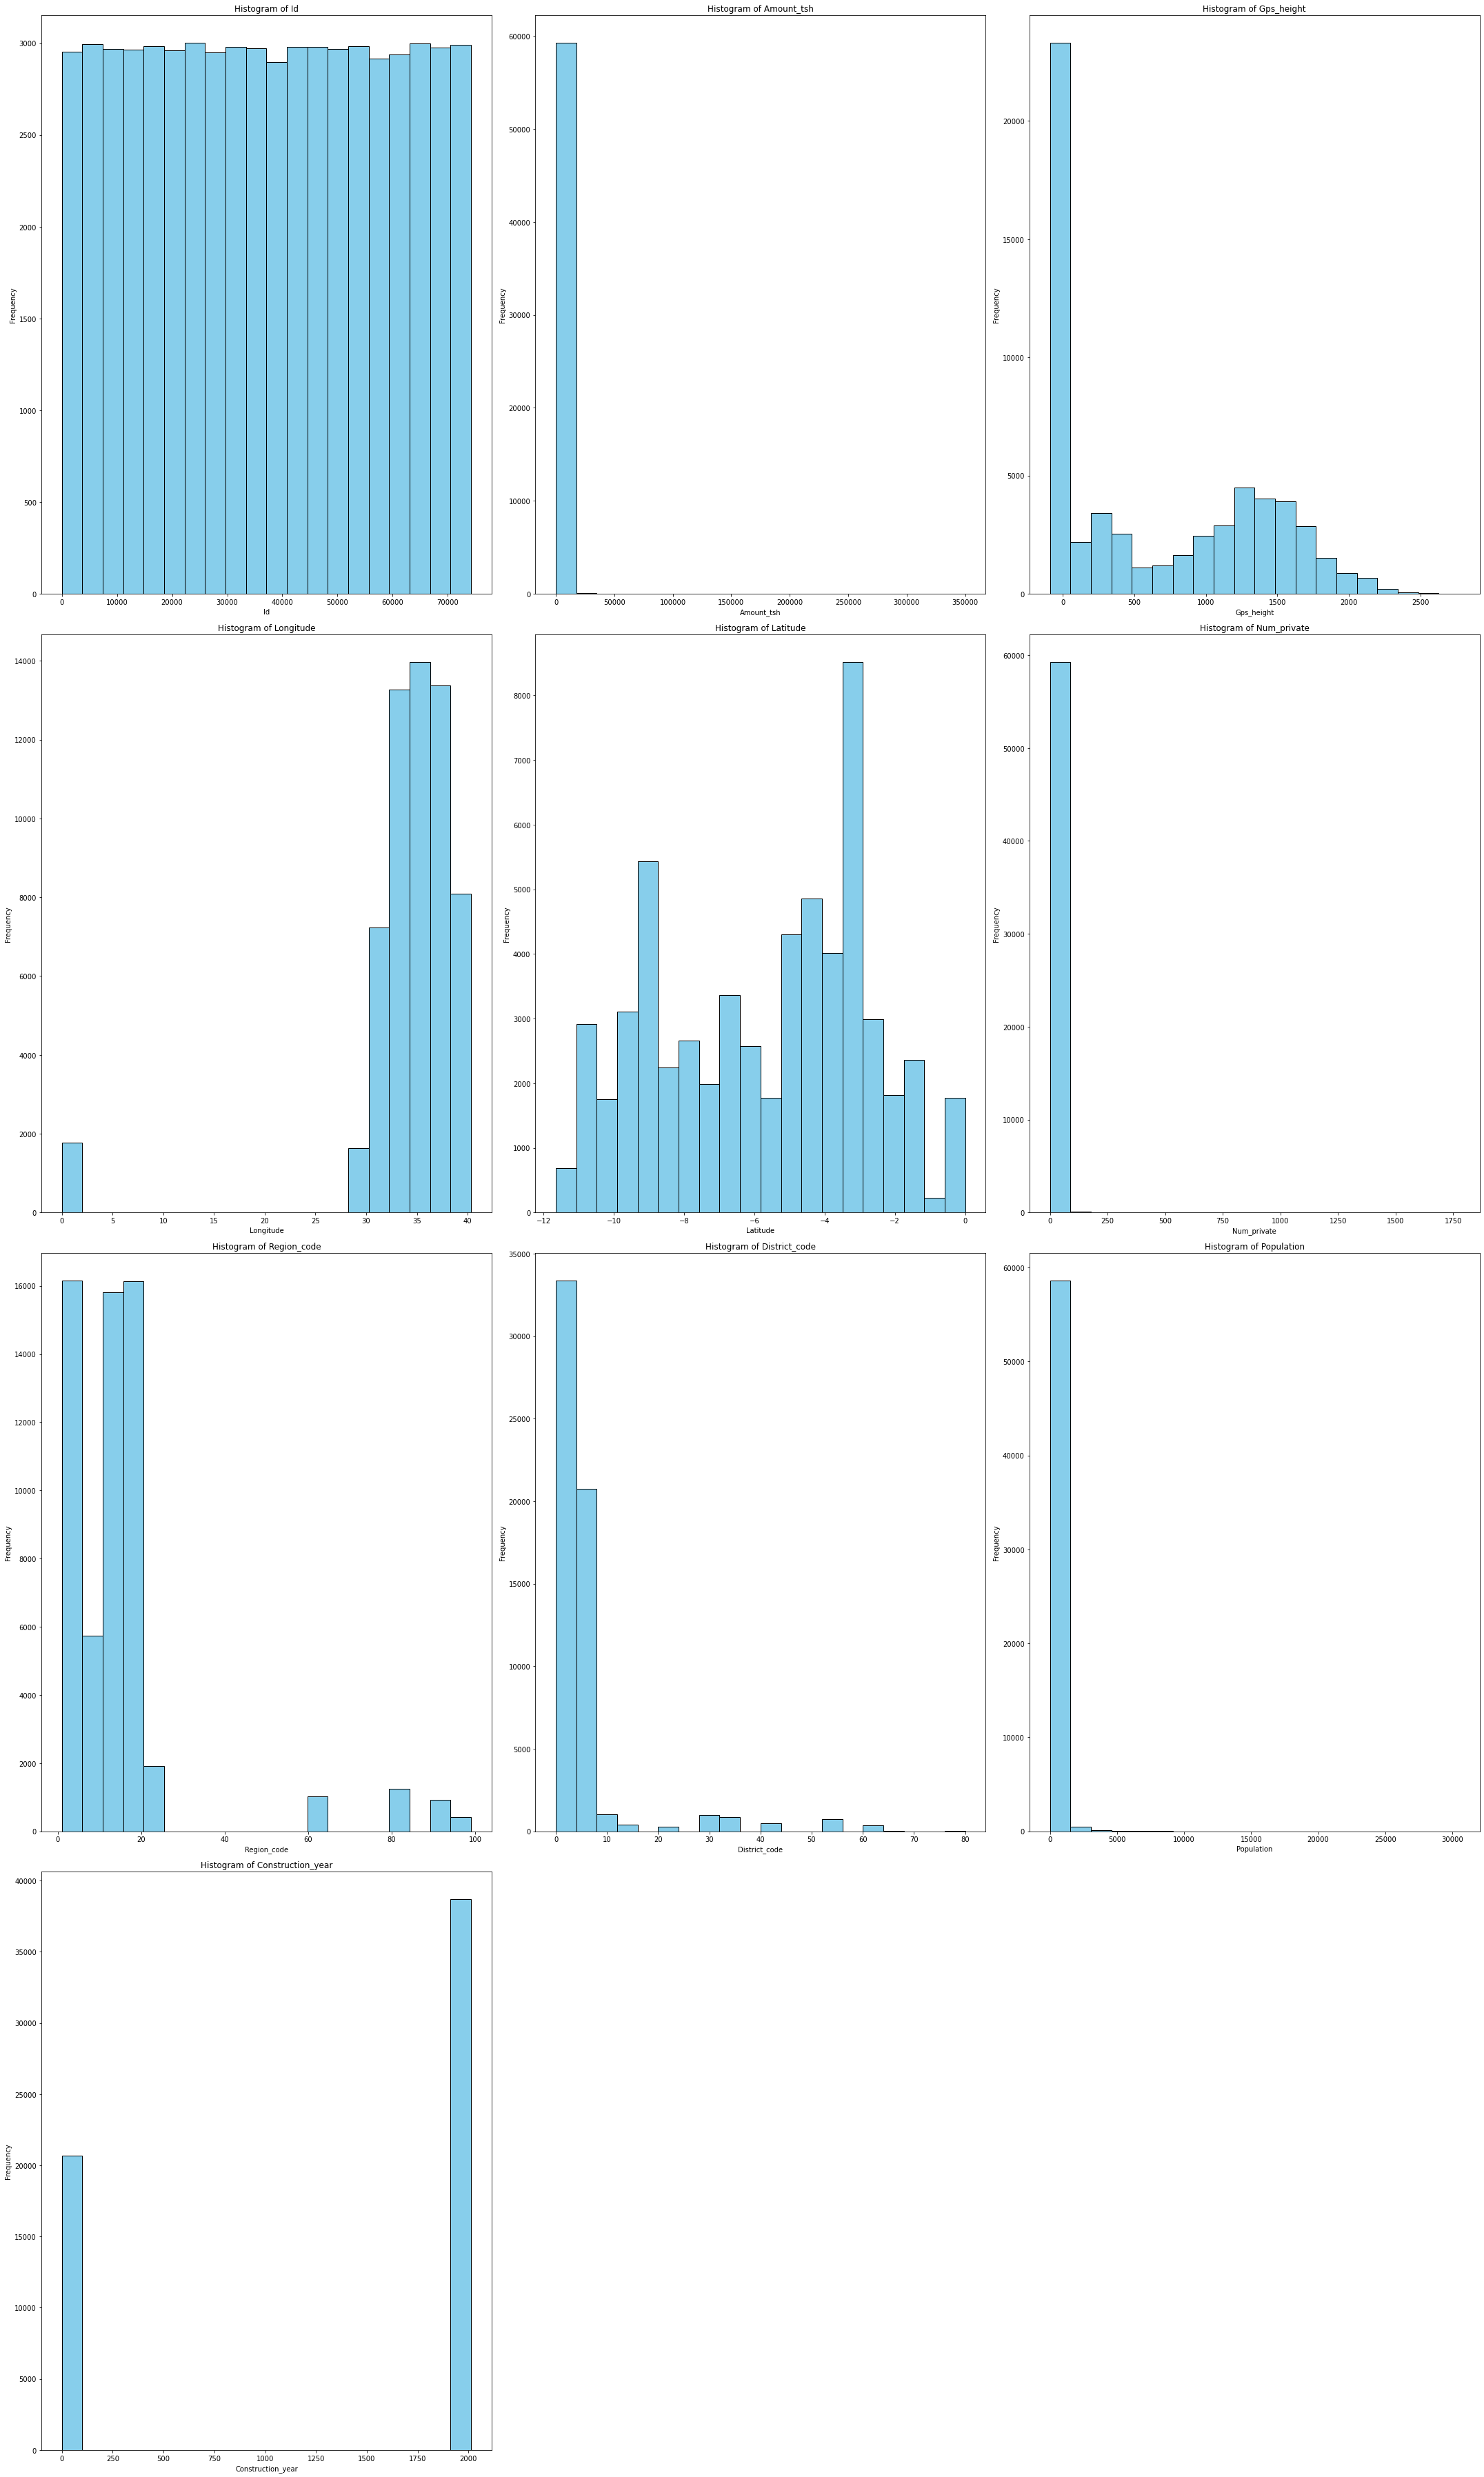

In [44]:
numerical_columns = df_cleaned.select_dtypes(include=['int64','float64']).columns

# Plotting histograms for numerical columns 
fig, axes = plt.subplots(nrows=math.ceil(len(numerical_columns)/3), ncols=3, figsize=(30, 5 * len(numerical_columns))) 
axes = axes.flatten()
for i, col in enumerate(numerical_columns): 
    df_cleaned[col].plot(kind='hist', ax=axes[i], bins=20, color='skyblue', edgecolor='black') 
    axes[i].set_title(f'Histogram of {col.capitalize()}') 
    axes[i].set_xlabel(col.capitalize()) 
    axes[i].set_ylabel('Frequency') 



#removing any extra subplots that may form
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout() 
plt.show()

### Insights

**amount_tsh** : majority of the total static head seem to lie between 0 and 5000 with high level at 0 this may indicate the vertical distance between the source and the extraction point is on the same level or there is no value for this data
**gps_height** : gps height seems to be normally distributed but with a positive skew due to majority of the values lying at 0. There is also presence of negative values. This indicates that some of wells are located below sea level
**longitudes** : the longitudes lie within the same area but there are longitudes that are 0. this indicates they are missing values in the longitudes field
**latitudes** : the latitudes lie where you expect Tanzania to be located
**Regioncode** : Region code shows that majority of the water point can be found in one region
**Population** : Population shows that the populations where this water points are located have low population. This might be accurate as abundance of wells in African countries are found in areas that are sparsely populated
**Construction_year** : The construction year shows that majority of the wells were built almost at the same time. The column has a lot of missing data

**Further Investigation**

- Missing values are located in longitudes and construction year
- num_private analyse what data is found on that column


In [45]:
#filling longitude mising values by the median value and removing extreme values in the latitude

df_cleaned['longitude'].where(df_cleaned['longitude']> 25, df_cleaned['longitude'].median(),inplace= True)

In [46]:
df_cleaned['latitude'].where(df_cleaned['latitude']<-1, df_cleaned['latitude'].median(),inplace = True)

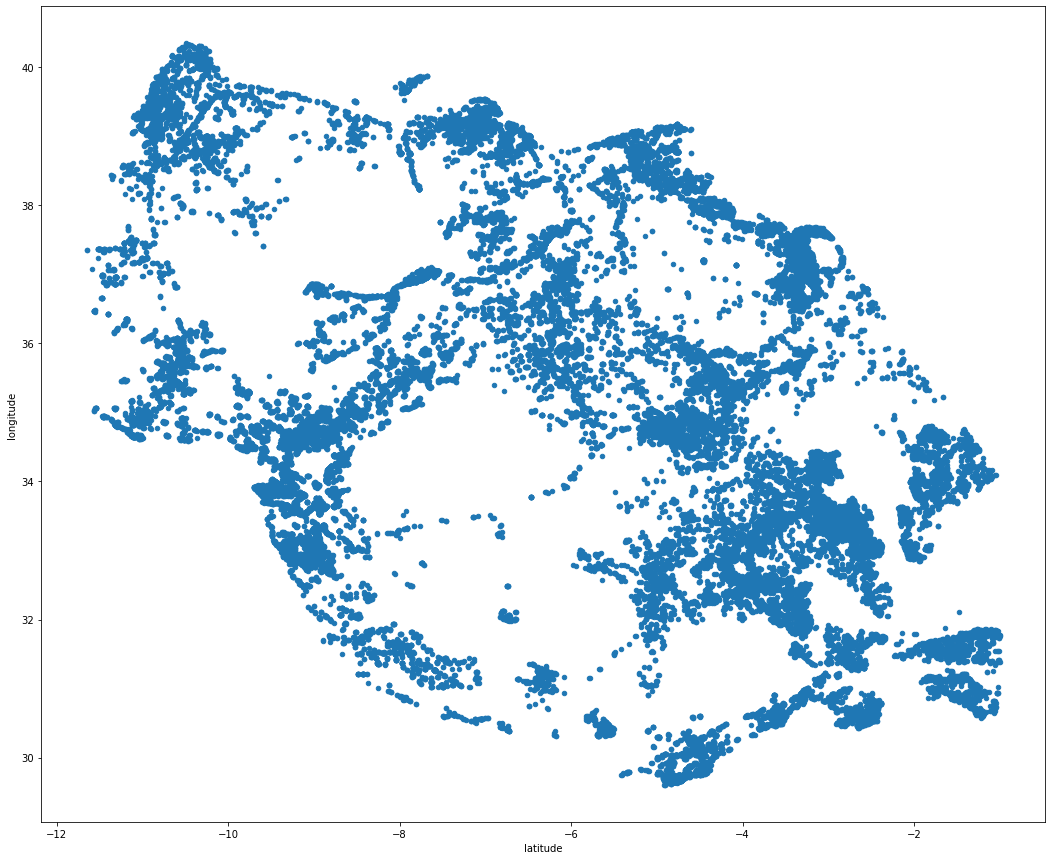

In [47]:

df_cleaned.plot(x='latitude',y='longitude',kind="scatter",figsize=(18,15))
plt.show();

<AxesSubplot:ylabel='Frequency'>

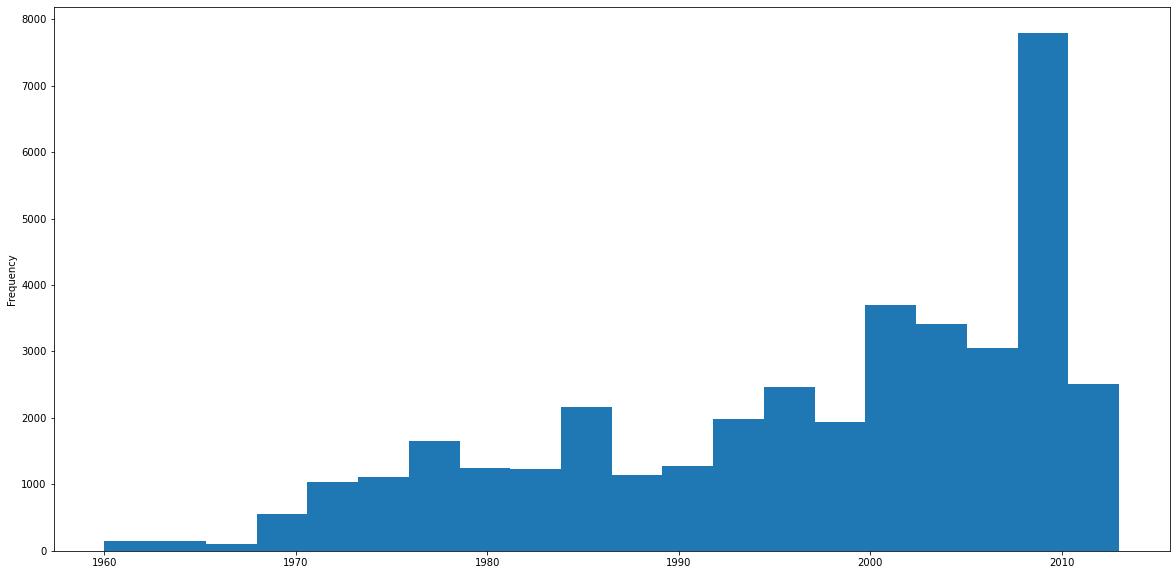

In [48]:
#plotting construnction year without the missing values
df_cleaned['construction_year'].where(df_cleaned['construction_year']>1750).plot(kind= 'hist', bins= 20, figsize= (20,10))

In [49]:
df_cleaned['construction_year'].describe()

count    59364.000000
mean      1301.441227
std        951.369704
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [50]:
df_cleaned['construction_year'].value_counts()

0       20673
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

We can see that majority of the values lie after 1970. Due to the large number of missing values we will create random years that lie between 1970 and 2010

<AxesSubplot:ylabel='Frequency'>

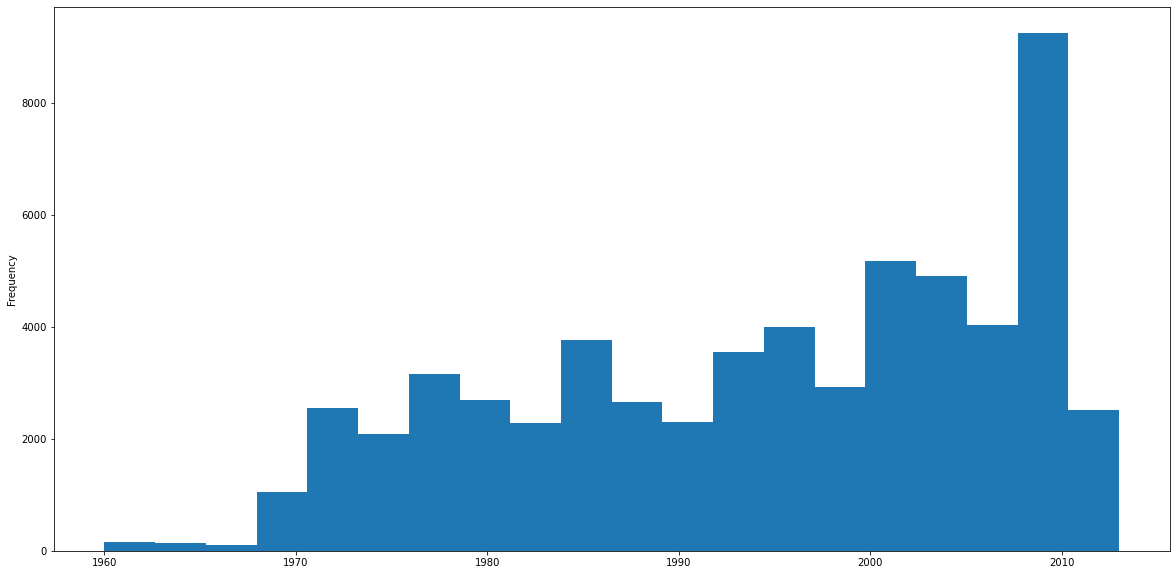

In [51]:
# Creating random construction years that lie inbetween 1970 and 2010
np.random.seed(seed= 42)
random_years = np.random.randint(1970,2010 +1, size= df_cleaned['construction_year'].value_counts()[0])

#replacing random values
df_cleaned.loc[df_cleaned['construction_year']== 0, 'construction_year'] = random_years

df_cleaned['construction_year'].plot(kind= 'hist', bins= 20, figsize= (20,10))


This provides a better distribution of what we would expect from the previous observations

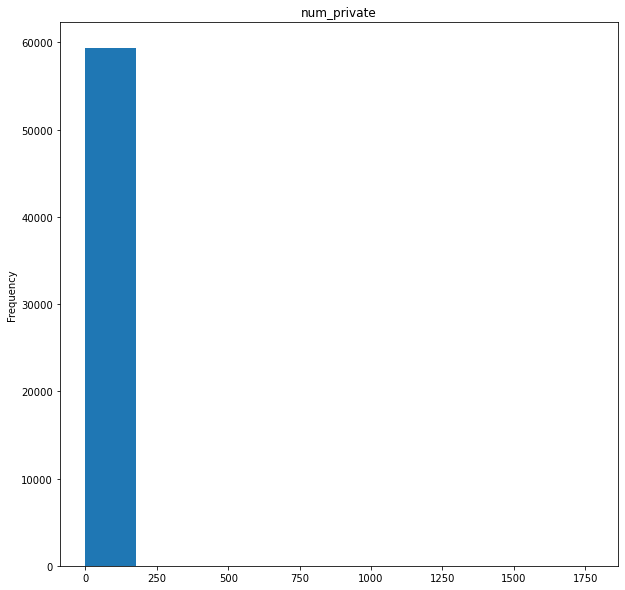

In [52]:
# num_private column

df_cleaned['num_private'].plot(kind= 'hist', bins= 10, figsize= (10,10))
plt.title("num_private")
plt.show()

# With lack of understanding of this column i will drop the column from the dataset

In [53]:
df_cleaned.drop(columns='num_private', inplace = True)

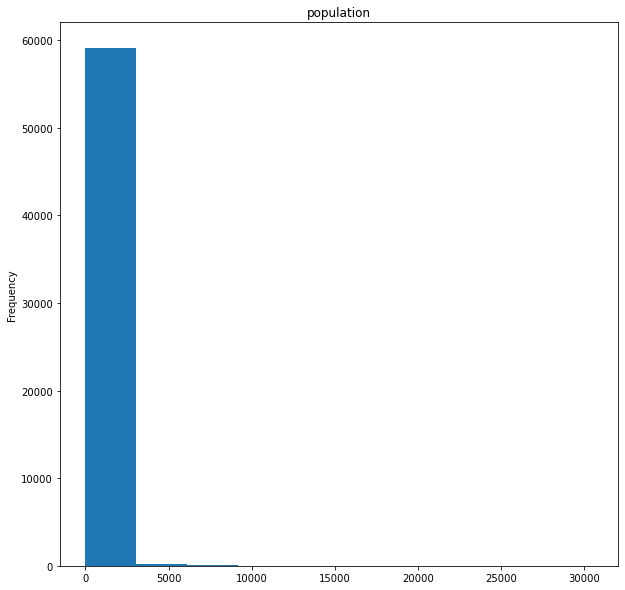

In [54]:


df_cleaned['population'].plot(kind= 'hist',bins= 10, figsize= (10,10))


plt.title("population")
plt.show()


The above columns seem to contain a lot of missing values 

<AxesSubplot:ylabel='Frequency'>

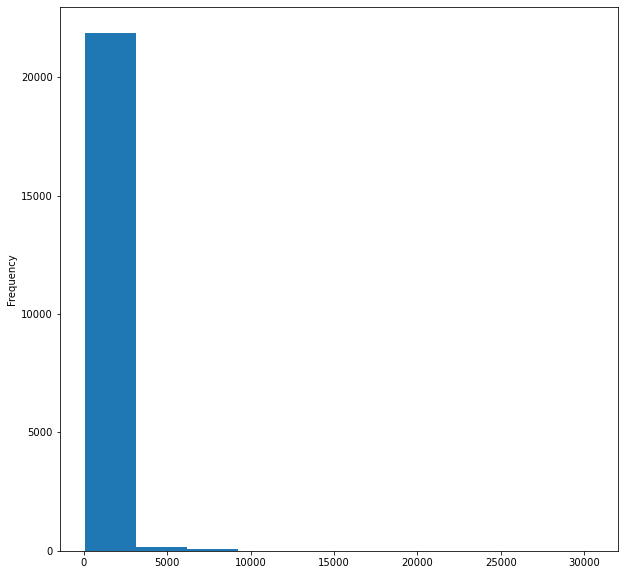

In [55]:
# checking how the datatset looks without the missing values plotted
df_cleaned['population'].where(df_cleaned['population']>100).plot(kind= 'hist',bins= 10, figsize= (10,10))

The dataset seems to lean close to the 0 value. This can be because if a well dries up the people living in the location tend to move or settle in other locations or it might still be missing values 

In [56]:
df_cleaned['population'].describe()

count    59364.000000
mean       180.019086
std        471.604294
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [57]:
df_cleaned['population'].value_counts()

0       21345
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

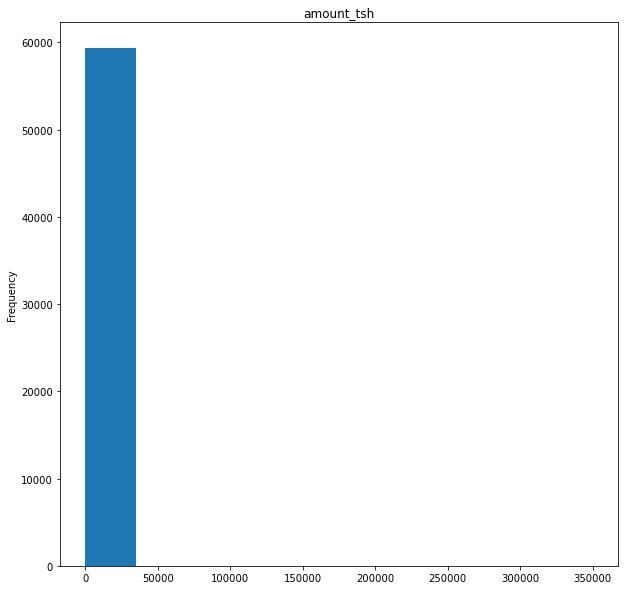

In [58]:
df_cleaned['amount_tsh'].plot(kind= 'hist',bins= 10, figsize= (10,10))


plt.title("amount_tsh")
plt.show()

<AxesSubplot:ylabel='Frequency'>

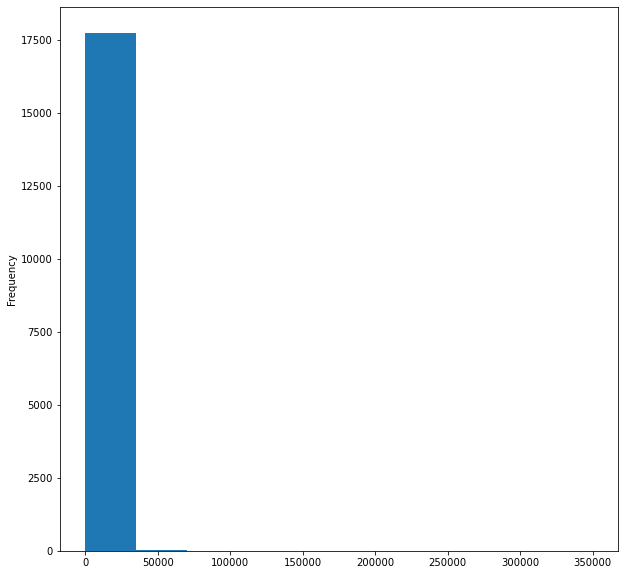

In [59]:
# checking how the datatset looks without the missing values plotted
df_cleaned['amount_tsh'].where(df_cleaned['amount_tsh']>0).plot(kind= 'hist',bins= 10, figsize= (10,10))

tsh starts for total static head which means the vertical distance between from the source to the discharge point. From the above visualisation it might mean that majority of the vertical distance is closer to zero or they can be missing values

In [60]:
df_cleaned['amount_tsh'].describe()

count     59364.000000
mean        317.843017
std        2998.473133
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [61]:
df_bivariate = df_cleaned.copy()

# Bivariate analysis

## Categorical columns

### stacked bar chart

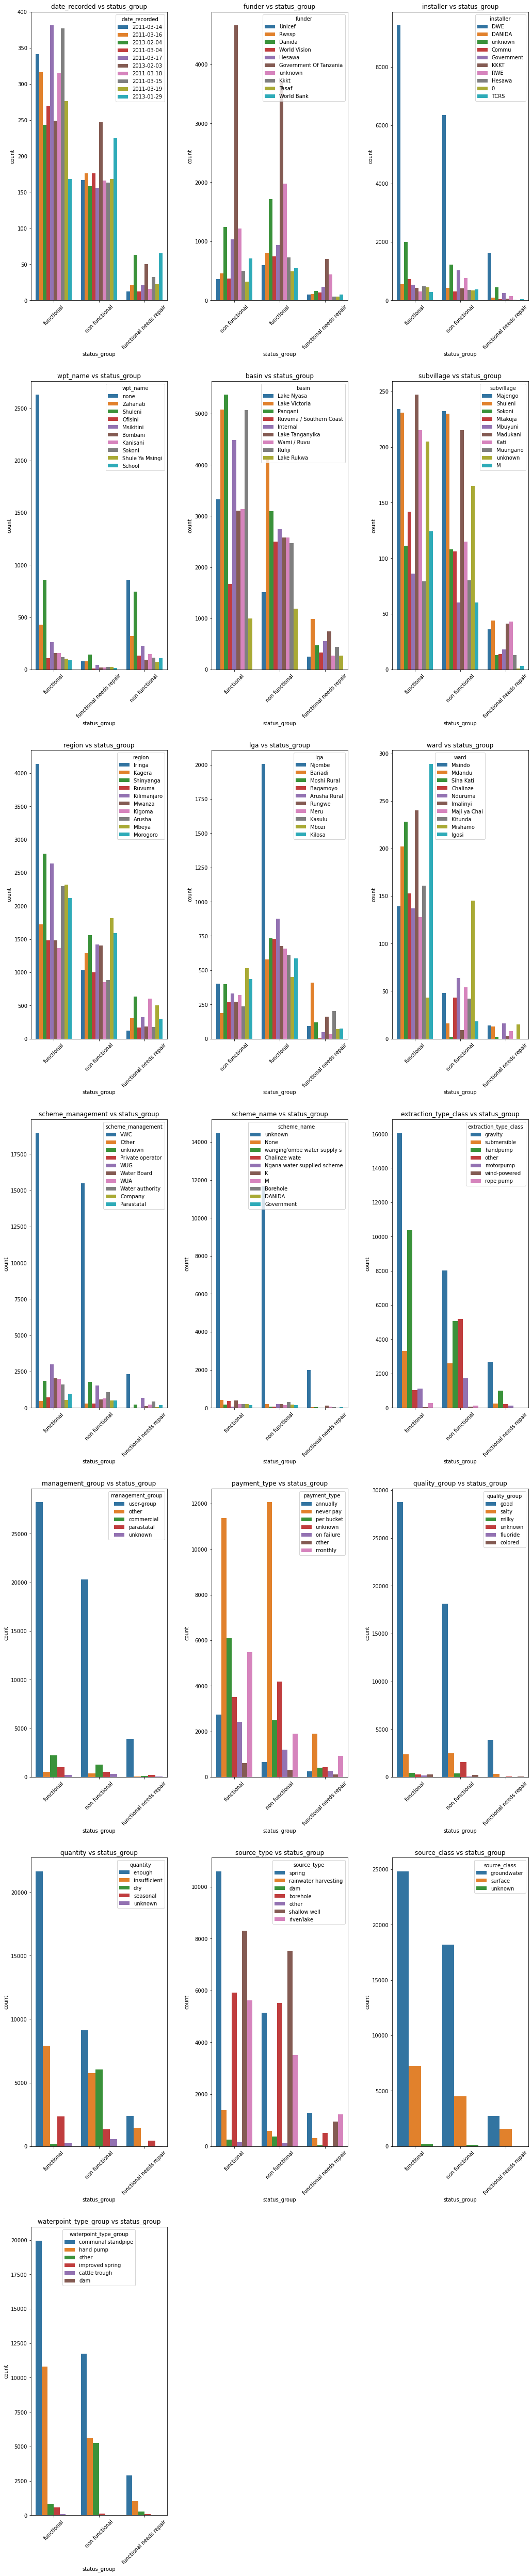

In [62]:

# Select categorical columns
categorical_columns = df_bivariate.select_dtypes(include=['object']).columns

# Plot bivariate analysis for categorical features
fig, axes = plt.subplots(nrows=math.ceil(len(categorical_columns)/3), ncols=3,figsize=(15, 70))
axes = axes.flatten()
for i, col in enumerate(categorical_columns[1:], start =1):
    if col != 'status_group': 
        top_values = df_bivariate[col].value_counts().head(10).index 
        sns.countplot(x='status_group', hue=col, data=df_bivariate[df_bivariate[col].isin(top_values)], ax=axes[i-1]) 
        axes[i-1].set_title(f'{col} vs status_group') 
        axes[i-1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

# Remove any unused subplots
for j in range(i , len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(pad=3.0)
plt.show()

#### Insights 

- **funder and status group** : The government of Tanzania builds the most wells, this shows that majority of the wells they build are also non functional, they also lead in the functional and need repairs categories
- **installer and status group** : District Water Engineer installed the most pumps in majority of the well so its safe to assume that they will be the most prevalent showcased on this chart
- **basin and status group** : In the Univariate analysis we noted that Lake Victoria was the source of the water for majority of the wells. But in the bivariate analysis we note that Lake Pangani wells are the most functional. Will be interesting to look
- **subvillage and statusgroup** : In the univariate analysis  Majengo, shuleni and Madukani had the most well built in their locations. In the bivariate analysis we can see that madukani has the most functional wells from the other two while Majengo subvillage has almost no difference whether well located in their location will be functional or non functional
- **region and statusgroup** : In the univariate analysis we saw that wells were majority built in Iringa. In the bivariate analysis we notice that majority of well built in Iringa are functional while the region mbeya which was our third most built area where wells were built has the most non functional wells
- **iga nad status group** : In the univariate analysis we noted that Njombe had the most well built in their location. It is interesting to note that wells built in this region also leads in that most of their wells are considered functional
- **ward and status group** : In the univariate analysis we noted that Igosi had the most number of wells located in their region. In the bivariate analysis we note that wells built in Igosi are also considered to be functional while well built in Mishamo are considered to be non functional
- **scheme_mgt and status group** : Village Water Committee (VWC) managemntt type managed the most wells. Due to majority of the wells being managed by a VWC its safe to assume they will have managed a lot of functional and non functional wells
- **management_group and status group** :user group had the majority type of managemnt group by a huge amount. Therefore its safe to assume that they will lead on both having functional and non functional wells
- **payment type and status group** : Most well, required the users not to pay for the service therefore they would lead in majority of the classes but is interesting to see that most none functional wells users were not paying while where the users had to pay for the service had less none functioning wells. This may indicate when users were not paying when the pump breaks the managemt group lacked the finances to repair the well
- **quality group vs status group** : Majority of the wells had good quality of water so as expected they would lead in majority of occurences in regards to the target variable
- **quantity group vs status group** : Majority of the wells were regarded to have water quantity that was considered to be enough therefore it will lead in majority of the classes in regards to the target variable. However in this column there is presence where data that mean almost the same thing are separate i.e insufficient and seasonal
- **sourcetype vs status group** : Springs and shallow well led in the most occurence type of water source.Its interesting to note that water that come from springs functional while water sourced from shallow wells have the most non functioning wells
- **source class vs status group** : Groundwater was the most prevalent source class so it correlates that it will be the most prevalent in regards to our target variable
- **waterpoint type vs status group** : Communal standpipe was the most prevalent in terms of type of waterpoint type group.It correlates that it will lead in majority with regards to the target variable


**Further Investigation**

- We have a lot of data with regards to location.To improve the performance of the model we have to drop some of the columns so to get a generalised location.
- We have to also remove data that are in regards to the names as they dont correlate with our target variable
- To get better information we will extract the year from that date recorded. We will then create a new column called year in service that is the year in between when the well was constructed to the year recorded


In [63]:
df_bivariate.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'source_class', 'waterpoint_type_group'],
      dtype='object')

In [64]:
# Removing location based columns and unecessary columns

df_bivariate.drop(columns=['wpt_name','subvillage','lga','ward','scheme_name'], inplace= True)

In [65]:
df_bivariate

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,source_class,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,True,VWC,False,1999,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,True,Other,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,250,True,VWC,True,2009,gravity,user-group,per bucket,good,enough,dam,surface,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,True,VWC,True,1986,submersible,user-group,never pay,good,dry,borehole,groundwater,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,0,True,unknown,True,2008,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,3,5,125,True,Water Board,True,1999,gravity,user-group,per bucket,good,enough,spring,groundwater,communal standpipe
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Rufiji,Iringa,11,4,56,True,VWC,True,1996,gravity,user-group,annually,good,enough,river/lake,surface,communal standpipe
59397,37057,functional,0.0,2011-04-11,unknown,0,unknown,34.017087,-8.750434,Rufiji,Mbeya,12,7,0,True,VWC,False,1988,handpump,user-group,monthly,fluoride,enough,borehole,groundwater,hand pump
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Rufiji,Dodoma,1,4,0,True,VWC,True,1987,handpump,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump


In [66]:
df_bivariate['date_recorded'].head()

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

In [67]:
# Extracting year from date_recorded

df_bivariate['date_recorded_year'] = df_bivariate['date_recorded'].str.extract(r'(\d{4})').astype(int)

df_bivariate.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,source_class,waterpoint_type_group,date_recorded_year
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,True,VWC,False,1999,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe,2011
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,True,Other,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2013
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,250,True,VWC,True,2009,gravity,user-group,per bucket,good,enough,dam,surface,communal standpipe,2013
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,True,VWC,True,1986,submersible,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,2013
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,0,True,unknown,True,2008,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2011


<AxesSubplot:ylabel='Frequency'>

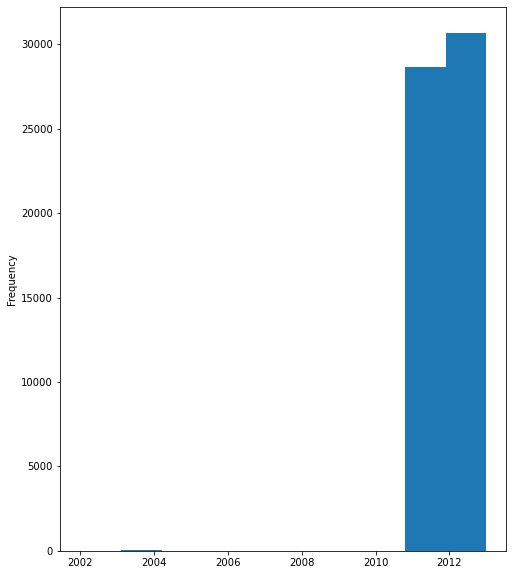

In [68]:
df_bivariate['date_recorded_year'].plot(x="date_recorded_year", kind = 'hist',bins= 10, figsize=(8,10))

In [69]:
# Lets subtract the recorded year from construction to discover how long the wells had operated before being recorded

df_bivariate['period']= df_bivariate['date_recorded_year'] - df_bivariate['construction_year']
df_bivariate

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,source_class,waterpoint_type_group,date_recorded_year,period
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,True,VWC,False,1999,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe,2011,12
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,True,Other,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2013,3
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,250,True,VWC,True,2009,gravity,user-group,per bucket,good,enough,dam,surface,communal standpipe,2013,4
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,True,VWC,True,1986,submersible,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,2013,27
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,0,True,unknown,True,2008,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2011,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,3,5,125,True,Water Board,True,1999,gravity,user-group,per bucket,good,enough,spring,groundwater,communal standpipe,2013,14
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Rufiji,Iringa,11,4,56,True,VWC,True,1996,gravity,user-group,annually,good,enough,river/lake,surface,communal standpipe,2011,15
59397,37057,functional,0.0,2011-04-11,unknown,0,unknown,34.017087,-8.750434,Rufiji,Mbeya,12,7,0,True,VWC,False,1988,handpump,user-group,monthly,fluoride,enough,borehole,groundwater,hand pump,2011,23
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Rufiji,Dodoma,1,4,0,True,VWC,True,1987,handpump,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump,2011,24


In [70]:
df_bivariate['period'].describe()

count    59364.000000
mean        17.508524
std         12.592847
min         -7.000000
25%          6.000000
50%         15.000000
75%         28.000000
max         53.000000
Name: period, dtype: float64

In [71]:
#lets drop rows that have period with negative values
df_bivariate = df_bivariate[df_bivariate['period'] >= 0]

In [72]:
# lets drop the date recorded column and date_recorded_year

df_bivariate.drop(columns= ['date_recorded','date_recorded_year'], inplace = True)


<ipython-input-72-0b0e4b0ff194>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bivariate.drop(columns= ['date_recorded','date_recorded_year'], inplace = True)


In [73]:
df_bivariate.columns

Index(['id', 'status_group', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'source_class', 'waterpoint_type_group', 'period'],
      dtype='object')

### Chi Square Test

In [74]:
#Define a function to perform a chi square tes
def chi_square_test(df, target, columns):
    results = {}
    for col in columns:
        contingency_table = pd.crosstab(df[target], df[col]) 
        chi2,p,dof,expected = chi2_contingency(contingency_table)
        results[col] = {'chi2':chi2,
                        'p-value': p}
    
    return results

In [75]:
# select target variable

target_variable = 'status_group'
# get thecategorical columns in a list
categorical_columns =df_bivariate.select_dtypes(include='object').columns.to_list()
#remove the status_group 
categorical_columns.pop(0)

results = chi_square_test(df= df_bivariate, target= target_variable, columns = categorical_columns)
for col, result in results.items(): 
    print(f"Column: {col}") 
    print(f"Chi2: {result['chi2']}, p-value: {result['p-value']}\n")


Column: funder
Chi2: 14171.889173609099, p-value: 0.0

Column: installer
Chi2: 14750.703708213303, p-value: 0.0

Column: basin
Chi2: 1923.5586810402722, p-value: 0.0

Column: region
Chi2: 4794.299507665105, p-value: 0.0

Column: scheme_management
Chi2: 1987.6020257769587, p-value: 0.0

Column: extraction_type_class
Chi2: 6921.90911467295, p-value: 0.0

Column: management_group
Chi2: 286.0752588490578, p-value: 3.774735857120648e-57

Column: payment_type
Chi2: 3966.0686916486497, p-value: 0.0

Column: quality_group
Chi2: 2094.1353027502073, p-value: 0.0

Column: quantity
Chi2: 11351.076397724744, p-value: 0.0

Column: source_type
Chi2: 1906.2723413088465, p-value: 0.0

Column: source_class
Chi2: 589.6893504275961, p-value: 2.6402697082320118e-126

Column: waterpoint_type_group
Chi2: 6106.112717515814, p-value: 0.0



- **Ho** : categories in the column does not affect if a well will be functional or not
- **H1** : categories in a column affects whether a well will be functional or not
- **alpha** : 0.05

- From the above the columns management_group and source_class have a pvalue greater than 0.5 this shows that the categories in the column makes us to accept the null hypothesis.We will drop those columns as they wont provide any relevant information to our models

- All other columns have a pvalue that is less than our alpha therefore we accept the alternate hypothesis

In [76]:
df_bivariate.drop(columns= ['management_group','source_class'], inplace = True)

<ipython-input-76-2b7d93c2b463>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bivariate.drop(columns= ['management_group','source_class'], inplace = True)


## Numerical columns

### Grouped by  and summary statistics

In [77]:
# Select numerical columns
numerical_columns = df_bivariate.select_dtypes(include=['number']).columns


summary_stats = df_bivariate.groupby('status_group')[numerical_columns]

summary_stats.describe()

id                                              \
                           count          mean           std   min       25%   
status_group                                                                   
functional               32233.0  37039.804269  21488.220554   1.0  18329.00   
functional needs repair   4314.0  37159.558646  21343.151470  20.0  18720.75   
non functional           22806.0  37224.724678  21421.266125   0.0  18777.25   

                                                    amount_tsh              \
                             50%       75%      max      count        mean   
status_group                                                                 
functional               36890.0  55683.00  74242.0    32233.0  462.150568   
functional needs repair  37196.0  55713.50  74233.0     4314.0  267.257302   
non functional           37295.0  55605.75  74247.0    22806.0  123.577813   

                                                                     \
                                 std  min  25%  50%   75%       max   
status_group                                                          
functional               3891.283025  0.0  0.0  0.0  50.0  350000.0   
functional needs repair  1925.682910  0.0  0.0  0.0  50.0  100000.0   
non functional           1110.553261  0.0  0.0  0.0   0.0  117000.0   

                        gps_height                                            \
                             count        mean         std   min  25%    50%   
status_group                                                                   
functional                 32233.0  740.620699  724.193896 -90.0  0.0  553.0   
functional needs repair     4314.0  628.043579  648.411933 -51.0  0.0  385.5   
non functional             22806.0  574.808296  642.777377 -59.0  0.0  293.0   

                                         longitude                       \
                             75%     max     count       mean       std   
status_group                                                              
functional               1405.00  2628.0   32233.0  35.183657  2.438589   
functional needs repair  1243.75  2770.0    4314.0  34.363175  2.755084   
non functional           1211.75  2627.0   22806.0  35.231041  2.683454   

                                                                     \
                               min        25%        50%        75%   
status_group                                                          
functional               29.607201  33.563526  34.972920  37.057862   
functional needs repair  29.640411  32.095377  34.661046  36.668220   
non functional           29.607122  33.133855  34.958871  37.567816   

                                   latitude                                 \
                               max    count      mean       std        min   
status_group                                                                 
functional               40.345193  32233.0 -5.841151  2.740961 -11.564324   
functional needs repair  40.283599   4314.0 -5.612188  2.650459 -11.649440   
non functional           40.344301  22806.0 -5.934087  2.831577 -11.586297   

                                                                region_code  \
                              25%       50%       75%       max       count   
status_group                                                                  
functional              -8.642598 -5.023822 -3.369217 -1.001988     32233.0   
functional needs repair -7.860745 -4.877181 -3.585260 -1.003345      4314.0   
non functional          -8.518379 -5.422287 -3.494041 -1.000585     22806.0   

                                                                           \
                              mean        std  min  25%   50%   75%   max   
status_group                                                                
functional               13.609655  14.598958  1.0  5.0  11.0  17.0  99.0   
functional needs repair  15.442513  16.352

### Boxplots

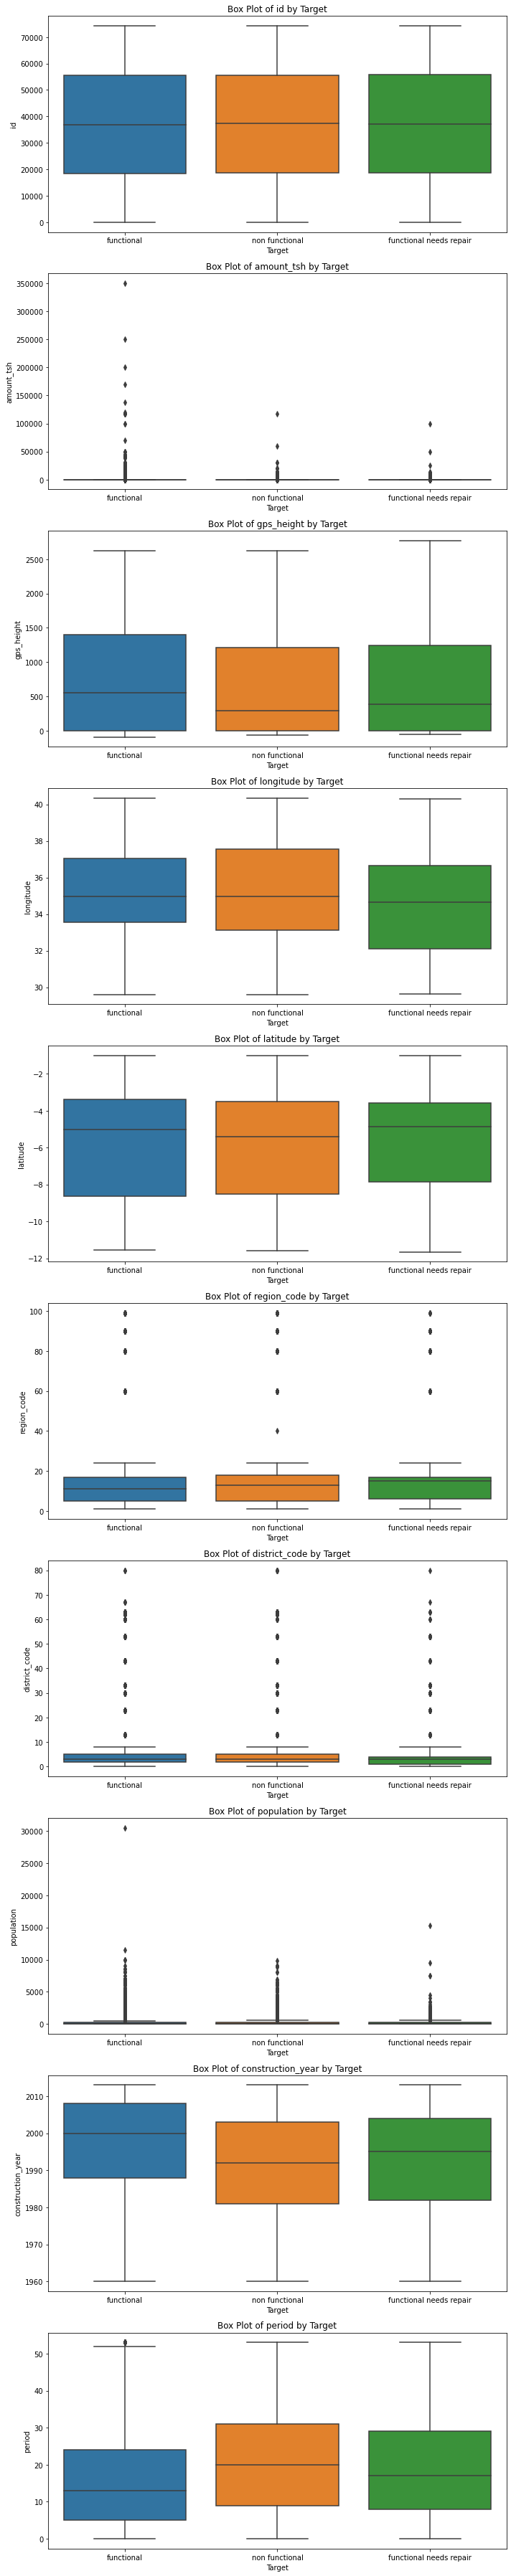

In [78]:
# Plot box plots for numerical columns 
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 5 * len(numerical_columns))) 
for i, col in enumerate(numerical_columns): 
    sns.boxplot(x='status_group', y=col, data=df_bivariate, ax=axes[i]) 
    axes[i].set_title(f'Box Plot of {col} by Target') 
    axes[i].set_xlabel('Target') 
    axes[i].set_ylabel(col) 

plt.tight_layout() 
plt.show()

#### insights

- **amount_tsh** - the columns seems to have a lot of outliers. It will be advisable to drop the column because of the high number of outliers
- **gps_height** - wells that functional seem to be found at higher altitudes than the wells that are considered non functional
- **population** - the column has a lot of outliers but functional wells tend to have higher population
- **construction year** - functional columns tend to be built newer than non functional ones
- **period** - functional wells tend to be younger though there is presence of an outlier on the dataset



In [79]:
# dropping unecessary columns

df_bivariate.drop(columns=["id","amount_tsh","district_code"],inplace = True)

<ipython-input-79-35c3c278c5d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bivariate.drop(columns=["id","amount_tsh","district_code"],inplace = True)


In [80]:
# checking the categories counts of region and the region code match
len(df_bivariate['region'].value_counts()) == len(df_bivariate['region_code'].value_counts())

False

In [81]:
region_code = df_bivariate.value_counts("region_code")
region = df_bivariate.value_counts("region")

region_code, region

(region_code
 11    5299
 17    4989
 12    4639
 3     4379
 5     4040
 18    3323
 19    3033
 2     3024
 16    2816
 10    2640
 4     2510
 1     2201
 13    2093
 14    1979
 20    1968
 15    1807
 6     1608
 21    1583
 80    1238
 60    1023
 90     916
 7      805
 99     423
 9      390
 24     326
 8      300
 40       1
 dtype: int64,
 region
 Iringa           5293
 Shinyanga        4980
 Mbeya            4639
 Kilimanjaro      4379
 Morogoro         4006
 Arusha           3350
 Kagera           3315
 Mwanza           3068
 Kigoma           2816
 Ruvuma           2640
 Pwani            2632
 Tanga            2544
 Dodoma           2201
 Singida          2093
 Mara             1968
 Tabora           1959
 Rukwa            1807
 Mtwara           1729
 Manyara          1583
 Lindi            1546
 Dar es Salaam     805
 dtype: int64)

In [82]:
# From an onlline search Tanzania has 33 regions therefore this means that region code has eroneous data. therefore we will drop the column

df_bivariate.drop(columns="region_code",inplace = True)

<ipython-input-82-0f4aaf0222fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bivariate.drop(columns="region_code",inplace = True)


In [83]:
df_multivariate = df_bivariate.copy()

# Multivariate analysis

## Correlation matrix


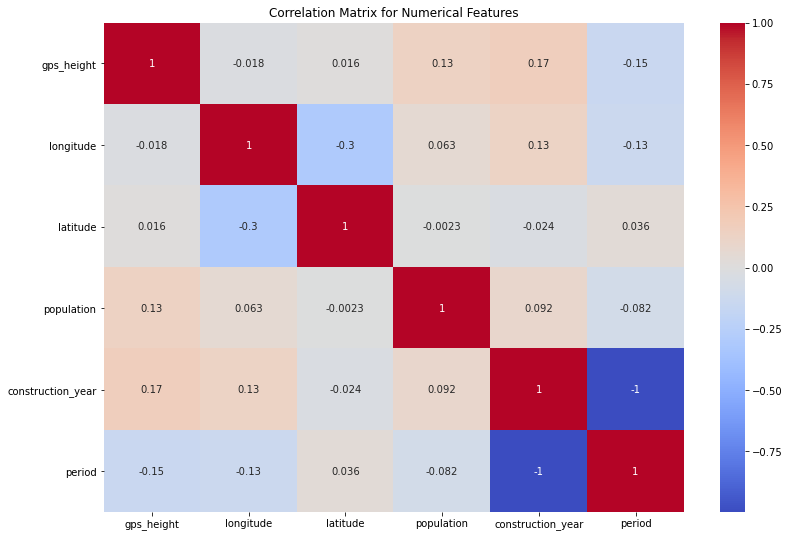

In [84]:
numerical_columns = df_multivariate.select_dtypes(include=['number'])


# correlation matrix for numerical features

corr_matrix = numerical_columns.corr()

# Display heatmap of correlations
plt.figure(figsize=(13, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()


### Insights

The coorreltion analysis shows there is no presence of a strong correlation between any of the numerical X variables. 
This is true except for the period in which we feature engineer as an additional information for our model

In [85]:
df_model = df_multivariate.copy()

# Modelling

- Target variable = status group

This is a classification problem. The aim of this project in accordance with our business problem is to predict whether given certain features if we can predict whether a well will be functional or not functional

## feature engineering

In [86]:
df_model.shape

(59353, 20)

In [87]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59353 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59353 non-null  object 
 1   funder                 59353 non-null  object 
 2   gps_height             59353 non-null  int64  
 3   installer              59353 non-null  object 
 4   longitude              59353 non-null  float64
 5   latitude               59353 non-null  float64
 6   basin                  59353 non-null  object 
 7   region                 59353 non-null  object 
 8   population             59353 non-null  int64  
 9   public_meeting         59353 non-null  bool   
 10  scheme_management      59353 non-null  object 
 11  permit                 59353 non-null  bool   
 12  construction_year      59353 non-null  int64  
 13  extraction_type_class  59353 non-null  object 
 14  payment_type           59353 non-null  object 
 15  qu

### target variable

In [88]:
target_variable = df_model.value_counts("status_group")
target_variable

status_group
functional                 32233
non functional             22806
functional needs repair     4314
dtype: int64

A logistic model is a binary model so we have to engineer our class into a binary classification i.e 
- both functional and functional and need repairs will be a 1
- non functional will be a 0

In [89]:
df_model["status_group"] = df_model['status_group'].map({"functional": 1, "functional needs repair": 1, "non functional": 0})

In [90]:
target_variable = df_model.value_counts("status_group")
target_variable

status_group
1    36547
0    22806
dtype: int64

### feature variables

#### funder

In [91]:
# lets check number of unique values that are in each of our catehorical columns. 

object_columns = df_model.select_dtypes(include=['object']).columns

object_column_unique = {col : df_model[col].nunique() for col in object_columns}

columns_unique_df =pd.DataFrame(list(object_column_unique.items()), columns= ['column_name', 'number_of_unique_values'])
columns_unique_df

,column_name,number_of_unique_values
0,funder,1897
1,installer,2143
2,basin,9
3,region,21
4,scheme_management,13
5,extraction_type_class,7
6,payment_type,7
7,quality_group,6
8,quantity,5
9,source_type,7


From the above we can see that funder and installer columns have a lot of unique values. To aid in our model performance we need to reduce its dimensionality

In [92]:
# We will filter our dataset to contain funders who hav funded over 500 projects
funder =df_model['funder'].value_counts()

funder_filtered_index = funder[funder> 500].index


In [93]:
#lets filter our dataframe with our filtered index
funder_filtered_columns =funder_filtered_index.to_list()

df_model_filtered = df_model[df_model['funder'].isin(funder_filtered_columns)].reset_index()





In [94]:
object_columns = df_model_filtered.select_dtypes(include=['object']).columns

object_column_unique = {col : df_model_filtered[col].nunique() for col in object_columns}

columns_unique_df =pd.DataFrame(list(object_column_unique.items()), columns= ['column_name', 'number_of_unique_values'])
columns_unique_df

,column_name,number_of_unique_values
0,funder,20
1,installer,546
2,basin,9
3,region,21
4,scheme_management,13
5,extraction_type_class,7
6,payment_type,7
7,quality_group,6
8,quantity,5
9,source_type,7


In [95]:
df_model_filtered.drop(columns="index", inplace= True)

In [96]:
df_model_filtered.shape

(32433, 20)

#### installer

In [97]:
installer = df_model_filtered["installer"].value_counts()
installer


DWE                    10375
unknown                 3618
Government              1722
DANIDA                  1047
RWE                      995
                       ...  
TSCR                       1
Mohamad Masanga            1
Korogwe water works        1
Got                        1
SELEPTA                    1
Name: installer, Length: 546, dtype: int64

The installer dataset has a lot of inconsistent data. We will create a dictionary so to have a more consistent data on that column


In [98]:
# Create a function to remove any special character found in a column

def remove_special_characters(text): 
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

In [99]:
df_model_filtered["installer"] = df_model_filtered["installer"].apply(remove_special_characters)
df_model_filtered["installer"] = df_model_filtered["installer"].str.capitalize()

In [100]:
installer = df_model_filtered["installer"].value_counts()
installer

Dwe                10389
Unknown             3618
Government          1757
Danida              1047
Rwe                  995
                   ...  
Mbusi mwita            1
Tscr                   1
Mohamad masanga        1
Ewe                    1
Selepta                1
Name: installer, Length: 482, dtype: int64

In [101]:
installer =df_model_filtered["installer"].value_counts()
installer

Dwe                10389
Unknown             3618
Government          1757
Danida              1047
Rwe                  995
                   ...  
Mbusi mwita            1
Tscr                   1
Mohamad masanga        1
Ewe                    1
Selepta                1
Name: installer, Length: 482, dtype: int64

In [102]:
#we will create a dictionary to correct spelling error that might were caused in data collection for the main installers
replacements = {
    "Dwe": "District Water Engineer","Government": "Central Government","Rwe":"Region Water Engineer","District council":"District Water Engineer",
    "0":"Unknown","Central government":"Central Government","Commu":"Community","Danid":"Danida","Gover":"Central Government","Centr":"Central Government","Idara ya maji":"Central Government","District water department":"District Water Engineer","Gove":"Central Government",
    "Central govt":"Central Government","Unisef":"UNICEF","Unicef":"UNICEF","Wizara ya maji":"Central Government","Region water department":"Region Water Engineer","Sengerema water department":"District Water Engineer","Distri":"District Water Engineer","Kkt":"KKKT","Kkkt":"KKKT","Tanzania government":"Central Government","Govern":"Central Government","Ministry of water":"Central Government","Would bank":"World Bank","World bank":"World Bank","District counci":"District Water Engineer",
    "RWe community":"Region Water Engineer","World vission":"World Vision","Ministry of water enginneer":"Central Government","Regional water":"Regional Water Engineer","Not known":"Unknown","Cental government":"Central Government","Cebtral governemnt":"Central Government","Tanzanian governemt":"Central Government","District water depar":"District Water Engineer", "Local":"Community",
    "World vision":"World Vision","Rwe community":"Region Water Engineer","Ministry of water engineer":"Central Government","Regional Water Engineer":"Region Water Engineer","Cebtral government":"Central Government","Kkt c":"KKKT","World":"World Bank","Villagers":"Community","Dwsp":"District Water Engineer","Rwssp":"Region Water Engineer"

}

In [103]:
df_model_filtered["installer"] = df_model_filtered["installer"].replace(replacements)

In [104]:
# Get value counts 
value_counts = df_model_filtered['installer'].value_counts() 
# Identify categories with counts less than 100 
categories_to_replace = value_counts[value_counts < 100].index 
# Replace these categories with 'Other' 
df_model_filtered['installer'] = df_model_filtered['installer'].apply(lambda x: 'Other' if x in categories_to_replace else x)

In [105]:
installer =df_model_filtered["installer"].value_counts()
installer

District Water Engineer    11769
Unknown                     4404
Central Government          3766
Other                       2205
Danida                      1670
Region Water Engineer       1235
Community                   1080
KKKT                         945
Hesawa                       913
World Vision                 692
Tcrs                         658
Ces                          610
Tasaf                        412
Norad                        365
UNICEF                       330
Wedeco                       309
World Bank                   289
Da                           281
Wu                           167
Dmdd                         121
Handeni trunk main           111
Consulting engineer          101
Name: installer, dtype: int64

In [106]:
object_columns = df_model_filtered.select_dtypes(include=['object']).columns

object_column_unique = {col : df_model_filtered[col].nunique() for col in object_columns}

columns_unique_df =pd.DataFrame(list(object_column_unique.items()), columns= ['column_name', 'number_of_unique_values'])
columns_unique_df

,column_name,number_of_unique_values
0,funder,20
1,installer,22
2,basin,9
3,region,21
4,scheme_management,13
5,extraction_type_class,7
6,payment_type,7
7,quality_group,6
8,quantity,5
9,source_type,7


In [107]:
df_model_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32433 entries, 0 to 32432
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           32433 non-null  int64  
 1   funder                 32433 non-null  object 
 2   gps_height             32433 non-null  int64  
 3   installer              32433 non-null  object 
 4   longitude              32433 non-null  float64
 5   latitude               32433 non-null  float64
 6   basin                  32433 non-null  object 
 7   region                 32433 non-null  object 
 8   population             32433 non-null  int64  
 9   public_meeting         32433 non-null  bool   
 10  scheme_management      32433 non-null  object 
 11  permit                 32433 non-null  bool   
 12  construction_year      32433 non-null  int64  
 13  extraction_type_class  32433 non-null  object 
 14  payment_type           32433 non-null  object 
 15  qu

In [108]:
# Lets change construction year to a discrete variable. To allow for better interpration.
 # creating new columns
df_model_filtered['decade'] = df_model_filtered['construction_year']
# Create a dictionary to map years to decades
decade_mapping = {
**dict.fromkeys(range(1960, 1970), '60s'),
**dict.fromkeys(range(1970, 1980), '70s'),
**dict.fromkeys(range(1980, 1990), '80s'),
**dict.fromkeys(range(1990, 2000), '90s'),
**dict.fromkeys(range(2000, 2010), '00s'),
**dict.fromkeys(range(2010, 2014), '10s')
}
# Apply the mapping to the 'decade' column
df_model_filtered['decade'] = df_model_filtered['decade'].map(decade_mapping)
df_model_filtered['decade'].value_counts()

00s    8610
90s    7826
70s    6710
80s    6489
10s    2357
60s     441
Name: decade, dtype: int64

In [109]:
# lets drop construction year
# We will also drop longitudes and latitudes for its complexity 

df_model_filtered.drop(columns= ["longitude","latitude","construction_year"], inplace= True)
df_model_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32433 entries, 0 to 32432
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   status_group           32433 non-null  int64 
 1   funder                 32433 non-null  object
 2   gps_height             32433 non-null  int64 
 3   installer              32433 non-null  object
 4   basin                  32433 non-null  object
 5   region                 32433 non-null  object
 6   population             32433 non-null  int64 
 7   public_meeting         32433 non-null  bool  
 8   scheme_management      32433 non-null  object
 9   permit                 32433 non-null  bool  
 10  extraction_type_class  32433 non-null  object
 11  payment_type           32433 non-null  object
 12  quality_group          32433 non-null  object
 13  quantity               32433 non-null  object
 14  source_type            32433 non-null  object
 15  waterpoint_type_gro

In [110]:
#handling boolean values

boolean_columns = df_model_filtered.select_dtypes(include="bool").columns.to_list()
df_model_filtered[boolean_columns]= df_model_filtered[boolean_columns].astype(int)

In [111]:
df_model_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32433 entries, 0 to 32432
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   status_group           32433 non-null  int64 
 1   funder                 32433 non-null  object
 2   gps_height             32433 non-null  int64 
 3   installer              32433 non-null  object
 4   basin                  32433 non-null  object
 5   region                 32433 non-null  object
 6   population             32433 non-null  int64 
 7   public_meeting         32433 non-null  int32 
 8   scheme_management      32433 non-null  object
 9   permit                 32433 non-null  int32 
 10  extraction_type_class  32433 non-null  object
 11  payment_type           32433 non-null  object
 12  quality_group          32433 non-null  object
 13  quantity               32433 non-null  object
 14  source_type            32433 non-null  object
 15  waterpoint_type_gro

In [112]:
#Exporting to tableau

#df_model_filtered.to_csv("data/clean_data.csv")

## Models

In [113]:
df_mdl = df_model_filtered.copy()

In [114]:
#Assigning target variables and independent variables

y = df_mdl["status_group"]
X= df_mdl.drop(columns="status_group")




In [118]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

In [119]:
# Lets create a dataframe to store our results

df_results = pd.DataFrame(columns=["Model","Scaler","Encoder","F1 Score","roc_auc score mean","roc_auc score std"])

In [ ]:
categorical_columns =  X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = X.select_dtypes(include=["int"]).columns.to_list()



['gps_height', 'population', 'public_meeting', 'permit', 'period']

### No scale , One hot enconder logistic regression



In [ ]:
encoder = OneHotEncoder(drop ="first", sparse = False)

#create pipeline for categorical transformation

cat_transformer = make_pipeline(encoder)

#create a preprocessor

preprocessor = ColumnTransformer(
    transformers= [
        ('num', 'passthrough', numerical_columns)
        ('cat',encoder,categorical_columns)
    ]
)

Lr = LogisticRegression